### Loading the super-tensor and creating the temporal networks

In this notebook we will explore the class __temporal_nets__ to compute preliminar results using network analysis.

In [1]:
# Importing the temporal network class
from   GDa.temporal_network              import temporal_network
from   GDa.graphics.plot_raster          import plot_nodes_raster_all_bands 
from   GDa.graphics.plot_coherence_dists import plot_pooled_coherence_dists, plot_pooled_coherence_dists_per_stage,plot_pooled_coherence_dists_per_stim
from   GDa.graphics.plot_adjacency       import plot_adjacency 
import numpy                 as     np
import networkx              as     nx
import matplotlib.pyplot     as     plt
import igraph                as     ig
import leidenalg
import scipy.signal
import time
from   tqdm                  import tqdm
from   joblib                import Parallel, delayed
from   scipy                 import stats

# Just an auxiliary function to sommoth plots
def smooth(x, w):
    return scipy.signal.fftconvolve(x, np.ones(w)/w, mode='same')
# Bands names
bands = [r'$\delta$', r'$\alpha$', r'$\beta$', r'$\gamma$ ']

To instantiate the __temporal_network__ we have to supply the monkey name, the session, and date to its constructor.

In [2]:
# Instantiating a temporal network object
net = temporal_network(monkey='lucy', session=1, date=150128)

When instantiated, the temporal network object will load the recording info for the monkey, date, and sesion specified as well as the super tensor;

The super-tensor has dimensions [Number of pairs, Number of frequency bands, Number of trials * Time] (i.e., the trials are concatenated). So far we are using the following bands:

- $\theta$  = [4,8]  Hz;
- $\alpha$  = [8,15]  Hz;
- $\beta$   = [15,30]  Hz;
- $\gamma$  = [30,60]  Hz;

It is possible to check which recording information was recordes by acessing the __session_info__ dictionary:

In [3]:
print('Recording info available:\n')
print(list(net.session_info.keys()))

Recording info available:

['nC', 'nP', 'nT', 'pairs', 'indt', 'fsample', 'tarray', 'channels_labels', 'dcue', 'dsm', 'stim', 'indch', 'areas', 't_cue_on', 't_cue_off', 't_match_on']


We can plot the super tensor to visualize the time series of link strength for each band (here we plot 10 trials for better visualization).

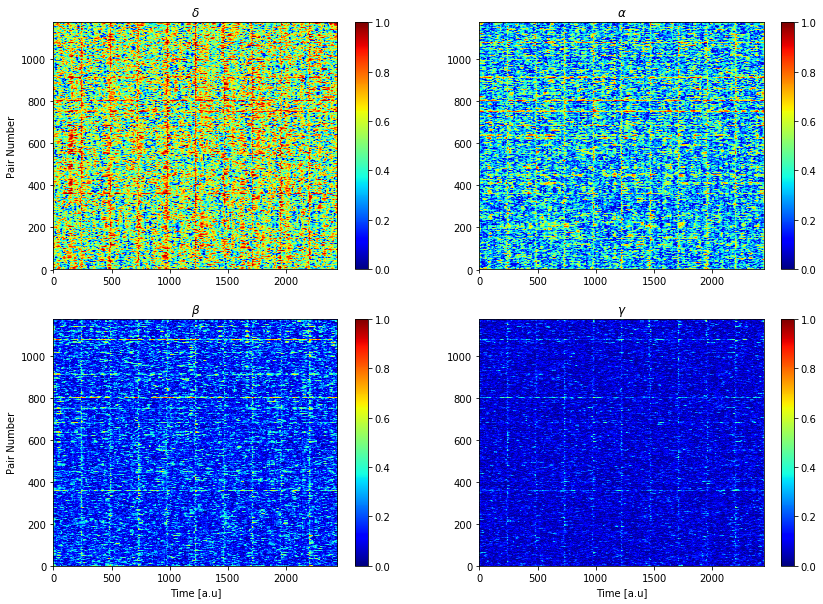

In [4]:
plot_nodes_raster_all_bands(net.super_tensor[:,:,:10*len(net.tarray)], 
                            0, 10*len(net.tarray), 
                            1, net.session_info['nP'], 0, 1, 
                            'Pair Number', 'Time [a.u]', bands, (14,10), 'jet')

Notice that strong vertical stripes appear at the beggining/ending of each trial in the image above. This is due artifacts during wavelet estimation of pairwise coherences. To remove the border artifacts it is possible to instantiate the __temporal_network__ class specifing the parameter __trim_borders__ = True, and a value to the parameter __wt__. Doing that the firs and last __wt__ time points of the super tensor and the time array will be removed.

In [5]:
# Instantiating a temporal network object specifing trim_borders and wt.
net =  temporal_network(monkey='lucy', session=1, date=150128, trim_borders=True, wt=20)

Now let's plot the super tensor for the first ten trials again and observe that now the vertical stripes are gone.

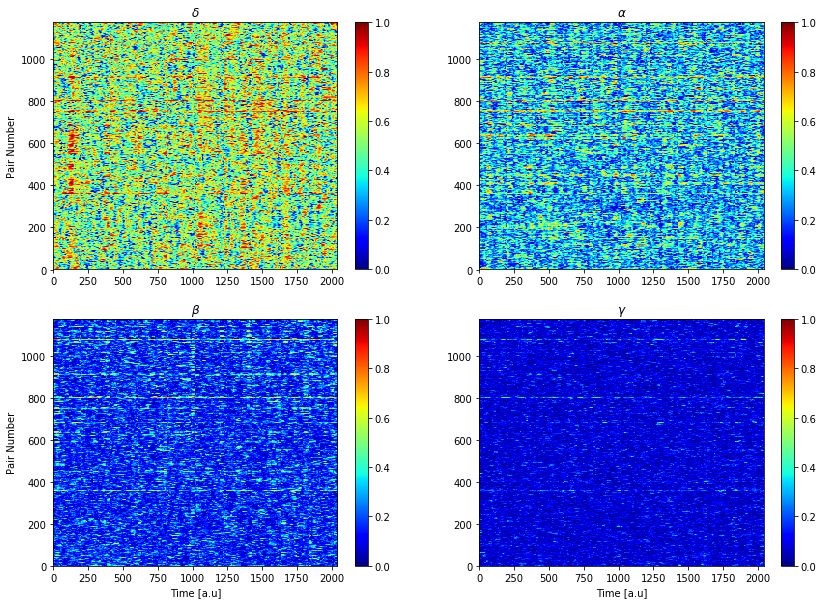

In [6]:
plot_nodes_raster_all_bands(net.super_tensor[:,:,:10*len(net.tarray)], 
                            0, 10*len(net.tarray), 
                            1, net.session_info['nP'], 0, 1, 
                            'Pair Number', 'Time [a.u]', bands, (14,10), 'jet')

Some of the network theory measures can be applied to the binarized version of the network and in order to do so it is necessary to define thresholds for the coherence values, this can be done with the method __compute_coherence_thresholds__, this method receives a parameter __q__ between $0$ and $1$ that specifies that only links with coherence values in the top $(1-q)$ of the distribution will be kept.

Threshold in $\delta$ band = 0.6973007619380951
Threshold in $\alpha$ band = 0.4740316814184189
Threshold in $\beta$  band = 0.2512036664145334
Threshold in $\gamma$ band = 0.12849100516239803


Text(0, 0.5, 'Threshold')

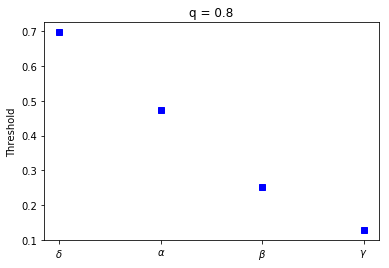

In [7]:
net.compute_coherence_thresholds(q = 0.8)

# Printing the threshold values 
print(r'Threshold in $\delta$ band = ' + str(net.coh_thr[0]))
print(r'Threshold in $\alpha$ band = ' + str(net.coh_thr[1]))
print(r'Threshold in $\beta$  band = ' + str(net.coh_thr[2]))
print(r'Threshold in $\gamma$ band = ' + str(net.coh_thr[3]))

plt.plot(range(4), net.coh_thr, 'bs')
plt.xticks(range(4), [r'$\delta$', r'$\alpha$', r'$\beta$', r'$\gamma$ '])
plt.title('q = 0.8')
plt.ylabel('Threshold')

To better visualize the threshold we can plot the pooled ditributions of coherence for each frequency band and indicate the threshold with a vertical line:

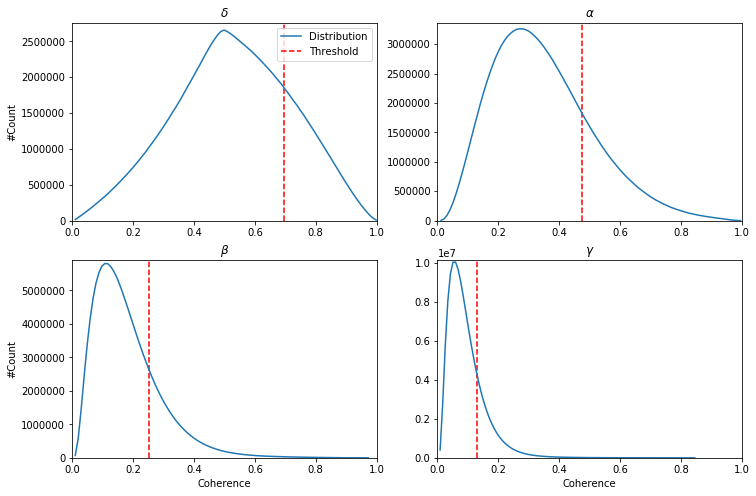

In [8]:
plot_pooled_coherence_dists(net.super_tensor, bins = 100, 
                            normed = False, 
                            thrs = [net.coh_thr[0], net.coh_thr[1], 
                                    net.coh_thr[2], net.coh_thr[3]],
                            titles = bands, figsize=(12,8))

Let's plot the binarized super tensor as well:

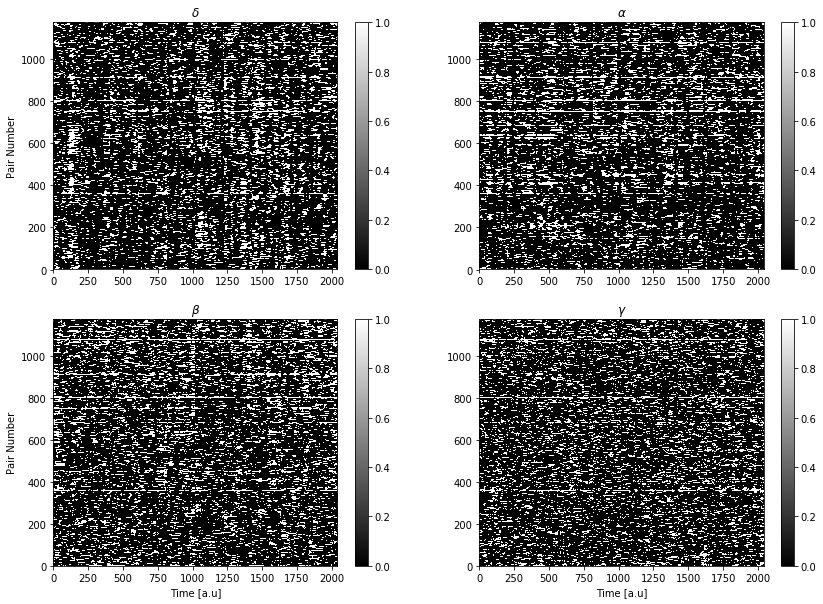

In [9]:
plot_nodes_raster_all_bands(net.super_tensor[:,:,:10*len(net.tarray)], 
                            0, 10*len(net.tarray), 
                            1, net.session_info['nP'], 0, 1, 
                            'Pair Number', 'Time [a.u]', bands, (14,10), 'gray',
                            thrs = [net.coh_thr[0], net.coh_thr[1], 
                                    net.coh_thr[2], net.coh_thr[3]],)

To use the Python package networkx to compute network theory quantities it is necessary to instantiate a __Graph__ object, to do so we have to provide an adjacency matrix to the __Graph__ method. Note that the super tensor is the edge representation of the network, but we can convert it to an adjacency matrix by calling the methdo __convert_to_adjacency__ in the class __temporal_network__. This method will create the variable __A__ inside the object.

In [10]:
net.convert_to_adjacency()

The adjacency matrix has dimensions [Number of channels, Number of channels Number of frequency bands, Number of trials * Time]. Let's plot both the weighted and binary adjancency matrix for the 10th observation (or time stamp) of the alpha band.

Text(0.5, 1.0, 'Binarized, $\\alpha$ band, observation 10')

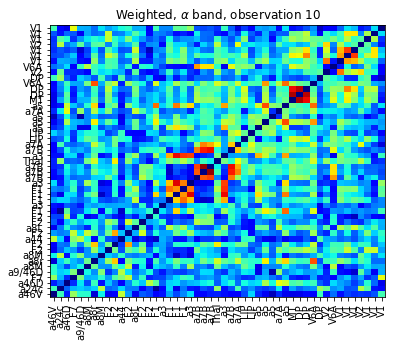

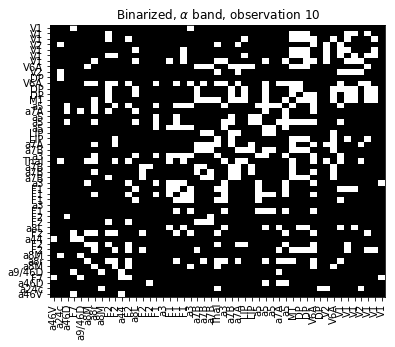

In [11]:
plot_adjacency(net.A[:,:,1,10], net.session_info['areas'], 'jet', (6,5))
plt.title(r'Weighted, $\alpha$ band, observation 10')
plot_adjacency(net.A[:,:,1,10]>net.coh_thr[1], net.session_info['areas'], 'gray', (6,5))
plt.title(r'Binarized, $\alpha$ band, observation 10')

Before moving the measures and preliminary results, during the analysis we may be interested to separate the measures we make by task stage, to do so we need some way to acess our arrays (super_tensor, adjacency matrix, node_degree...) in an specific stage. Using the method __create_stages_time_grid__, four array will be created inside the object: __t_baseline__, __t_cue__, __t_delay__, and __t_match__. Using those array any stage can be acessed easily, let's suposse you want the super tensor values only for the delay period in alpha band, you can retrieve this values by doing:

```net.super_tensor[:,1,net.t_baseline] ```

In [12]:
# Creating stages grid
net.create_stages_time_grid()

Now let's plot for each trial the duration of each period

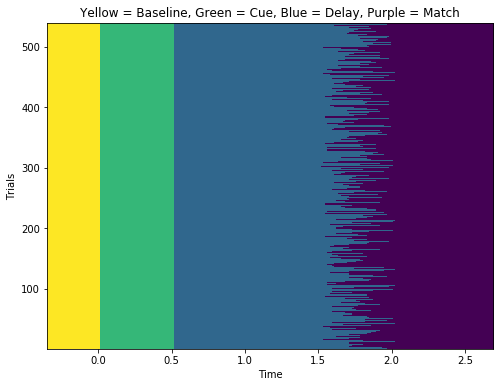

In [13]:
stages = np.zeros([net.session_info['nT'],len(net.tarray)])
ii     = [net.t_baseline.reshape(net.session_info['nT'],len(net.tarray)), 
          net.t_cue.reshape(net.session_info['nT'],len(net.tarray)), 
          net.t_delay.reshape(net.session_info['nT'],len(net.tarray)),
          net.t_match.reshape(net.session_info['nT'],len(net.tarray))]
for i in range(4):
    stages = stages - i * ii[i]
    
plt.figure(figsize = (8,6))
plt.imshow(stages, aspect='auto',cmap='viridis',origin='lower', extent=[net.tarray[0],net.tarray[-1],1,540])
plt.ylabel('Trials')
plt.xlabel('Time')
plt.title('Yellow = Baseline, Green = Cue, Blue = Delay, Purple = Match')
plt.savefig('figures/layerwise_net/stages.png')

Similarly to separating the measurements by task stage, we could be insterested in separating them by cue type (i.e., by differenciating the cue presented to the monkey), to create the grid which allows us to acess trials were a specific cue was presented to the monkey the method __create_stim_grid__. This method will create an array named __stim_grid__ inside the __temporal_network__ object, this array will have the shape [Number of cues, Trials * Time]. Let's suposse you want the super tensor values in the alpha band only for the second cue type presented, you can retrieve this values by doing:

```net.super_tensor[:,1,net.stim_grid[1]] ```

In [14]:
net.create_stim_grid()

We can now visualize, for instance, which trials received each cue type (for the first 20 trials):

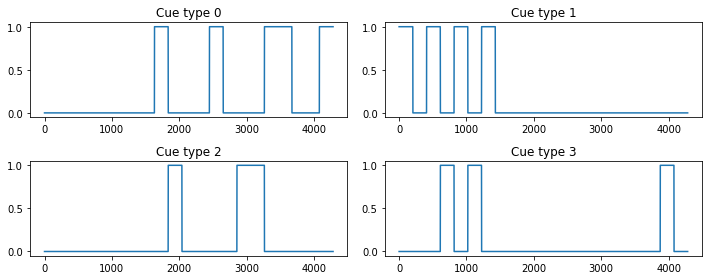

In [15]:
plt.figure(figsize=(10,4))
for i in range(net.stim_grid.shape[0]-1):
    plt.subplot(2,2,i+1)
    plt.plot(net.stim_grid[i,:21*len(net.tarray)])
    plt.title('Cue type ' + str(i))
plt.tight_layout()

Finally, since the results for the binarized network will depend on the threshold choice it is important to study the fraction of retained links as a function of $q$ for each band and task stage.

In [21]:
# Values of q used
q_list     = np.linspace(0.2, 0.9, 10)
n_retained = np.zeros([len(q_list), len(net.bands), 4]) # [Values of q, Number of bands, Number of stages]
# Computing the threshold for the specific q value
for i in tqdm( range( len( q_list) ) ):
    net.compute_coherence_thresholds(q = q_list[i])
    for j in range( len(net.bands) ):
        # Binary super tensor
        bst               = net.super_tensor[:,j,:] > net.coh_thr[j]
        n_retained[i,j,0] = bst[:,net.t_baseline].sum() / (net.session_info['nP'] * net.t_baseline.sum())
        n_retained[i,j,1] = bst[:,net.t_cue].sum()      / (net.session_info['nP'] * net.t_cue.sum())
        n_retained[i,j,2] = bst[:,net.t_delay].sum()    / (net.session_info['nP'] * net.t_delay.sum())
        n_retained[i,j,3] = bst[:,net.t_match].sum()    / (net.session_info['nP'] * net.t_match.sum())

# Set q to 0.80 again
net.compute_coherence_thresholds(q=.8)

100%|██████████| 10/10 [09:47<00:00, 58.75s/it]


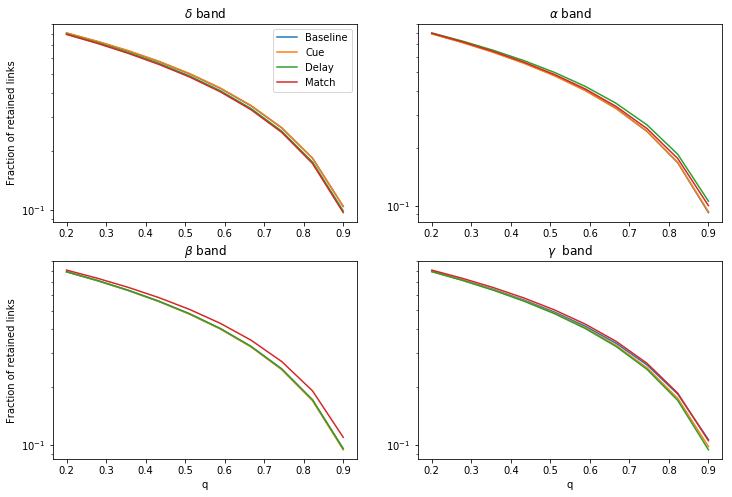

In [23]:
plt.figure(figsize=(12,8))
for j in range( len(net.bands) ):
    plt.subplot(2,2,j+1)
    plt.semilogy(q_list, n_retained[:,j,0], label = 'Baseline')
    plt.semilogy(q_list, n_retained[:,j,1], label = 'Cue')
    plt.semilogy(q_list, n_retained[:,j,2], label = 'Delay')
    plt.semilogy(q_list, n_retained[:,j,3], label = 'Match')
    plt.title(bands[j] + ' band')
    if j == 0:
        plt.legend()
    if j == 2 or j == 3:
        plt.xlabel('q')
    if j == 0 or j == 2:
        plt.ylabel('Fraction of retained links')

### Analysing the dependece of coherence distributions on frequency, stage, and cue of link weights 

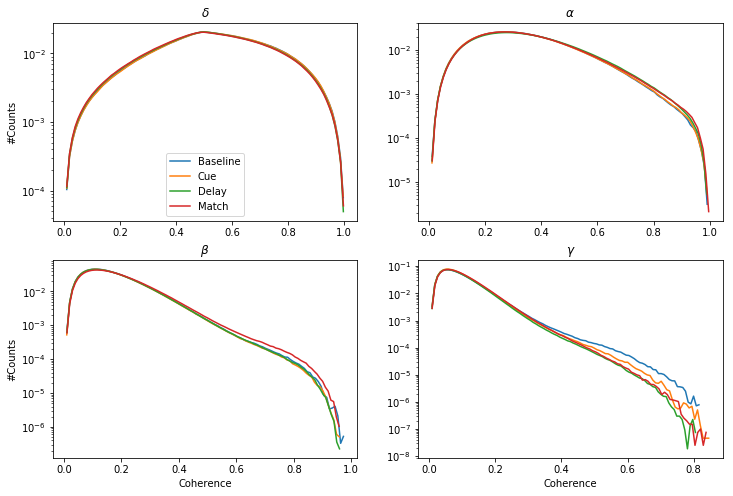

In [16]:
plot_pooled_coherence_dists_per_stage(net.super_tensor, 
                                      [net.t_baseline, net.t_cue, net.t_delay, net.t_match],
                                      bins = 100, normed = True, titles = bands, figsize=(12,8))

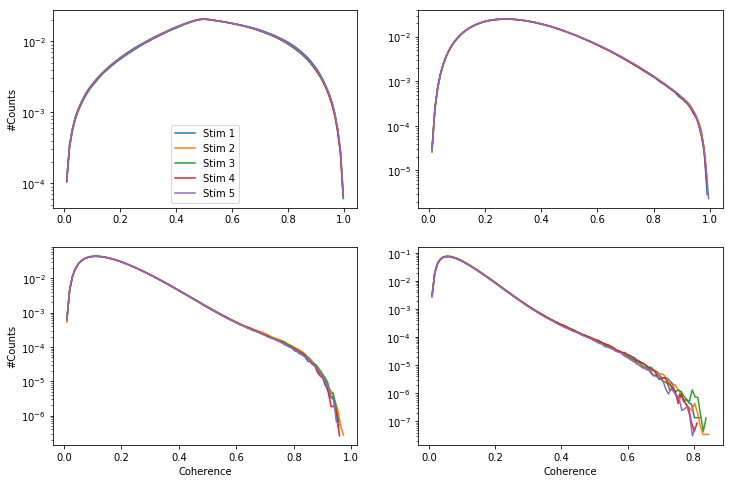

In [17]:
plot_pooled_coherence_dists_per_stim(net.super_tensor, 
                                      net.stim_grid,
                                      bins = 100, normed = True, titles = bands, figsize=(12,8))

### Null models and temporal correlations

It is possible to create null models for the adjacency matrix by using the method __create_null_model__, it i possible to create a null model by randomizing the edges by setting the parameter __randomize='edges'__, or by permuting the time layers by setting __randomize='time'__. The adjacency matrix for the null model is stored on the variable __A_null__. After creating the null models we can compare, for instance, compute the temporal correlation of the adjacency matrices for the original network and the randomized ones using the function __compute_temporal_correlation__.

In [19]:
CC_re = np.zeros(10) # Randomized edges
CC_rt = np.zeros(10) # Randomized layers
# Original network
CC_on = net.compute_temporal_correlation(band = 1, thr = net.coh_thr[1], tau = 1, on_null = False)
for i in tqdm( range(10) ):
    # Randomize on edges
    net.create_null_model(randomize = 'edges')
    CC_re[i] = net.compute_temporal_correlation(band = 1, thr = net.coh_thr[1], tau = 1, on_null = True)
    # Randomize on time
    net.create_null_model(randomize = 'time')
    CC_rt[i] = net.compute_temporal_correlation(band = 1, thr = net.coh_thr[1], tau = 1, on_null = True)

/home/vinicius/GrayData-Analysis/GDa/temporal_network.py:274: RuntimeWarning: invalid value encountered in true_divide
  Ci  = np.nansum(( num / den ), axis=1) / (A.shape[-1] - 1)
100%|██████████| 10/10 [08:39<00:00, 51.92s/it]


([<matplotlib.axis.XTick at 0x7f44da1a2400>,
 <a list of 2 Text xticklabel objects>)

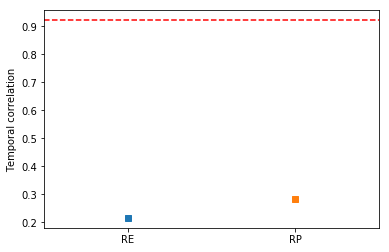

In [21]:
plt.errorbar(1, CC_re.mean(), CC_re.std(), marker='s')
plt.errorbar(3, CC_rt.mean(), CC_rt.std(), marker='s')
plt.hlines(CC_on, 0, 4, linestyle='--', color = 'r')
plt.xlim([0,4])
plt.ylabel('Temporal correlation')
plt.xticks([1,3], ['RE', 'RP'])

### Node strength/degree

Next we can compute a few network measures in the data, as a general rule if the parameter __thr__ is set to __None__ in those methods the weighted version of the measure will be computed (networkx), and the binarized (networkx or igraph) otherwise. 

Let's start by computing the node strength/degree using the method __compute_nodes_degree__.


__OBSERVATION__: Since computing node strength/degree is straightfoward, once the adjacency matrix are in hand the method __compute_nodes_degree__ does not rely on networkx.

In [26]:
# Computing node strength for each band
st_delta = net.compute_nodes_degree(0, thr = None)
st_alpha = net.compute_nodes_degree(1, thr = None)
st_beta  = net.compute_nodes_degree(2, thr = None)
st_gamma = net.compute_nodes_degree(3, thr = None)

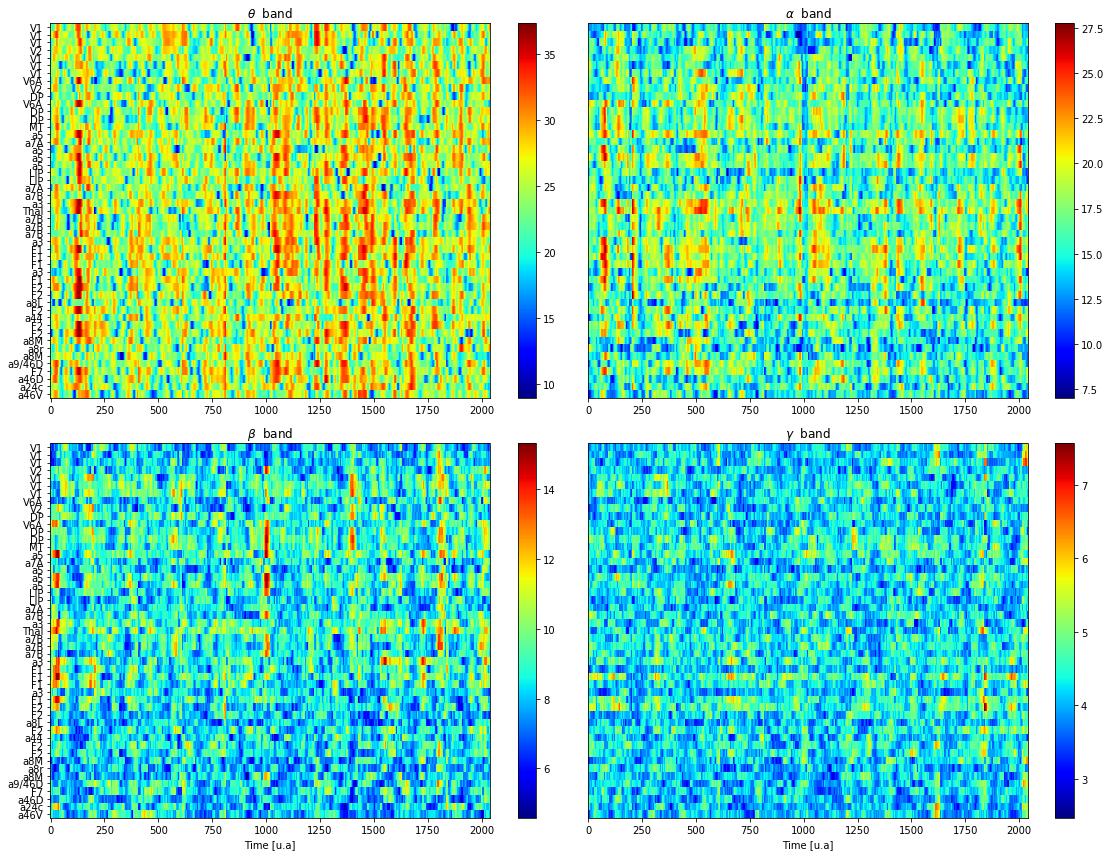

In [17]:
plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
plt.imshow(st_delta[:,:10*len(net.tarray)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.yticks(range(49), net.session_info['areas'])
plt.title(r'$\theta$  band')
plt.subplot(2,2,2)
plt.imshow(st_alpha[:,:10*len(net.tarray)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.title(r'$\alpha$  band')
plt.yticks([])
plt.subplot(2,2,3)
plt.imshow(st_beta[:,:10*len(net.tarray)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.title(r'$\beta$  band')
plt.yticks(range(49), net.session_info['areas'])
plt.xlabel('Time [u.a]')
plt.subplot(2,2,4)
plt.imshow(st_gamma[:,:10*len(net.tarray)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.yticks([])
plt.title(r'$\gamma$  band')
plt.xlabel('Time [u.a]')
plt.tight_layout()
plt.savefig('figures/layerwise_net/strength_raster.png')

In [18]:
# Computing node degree for each band
dg_delta = net.compute_nodes_degree(0, thr = net.coh_thr[0])
dg_alpha = net.compute_nodes_degree(1, thr = net.coh_thr[1])
dg_beta  = net.compute_nodes_degree(2, thr = net.coh_thr[2])
dg_gamma = net.compute_nodes_degree(3, thr = net.coh_thr[3])

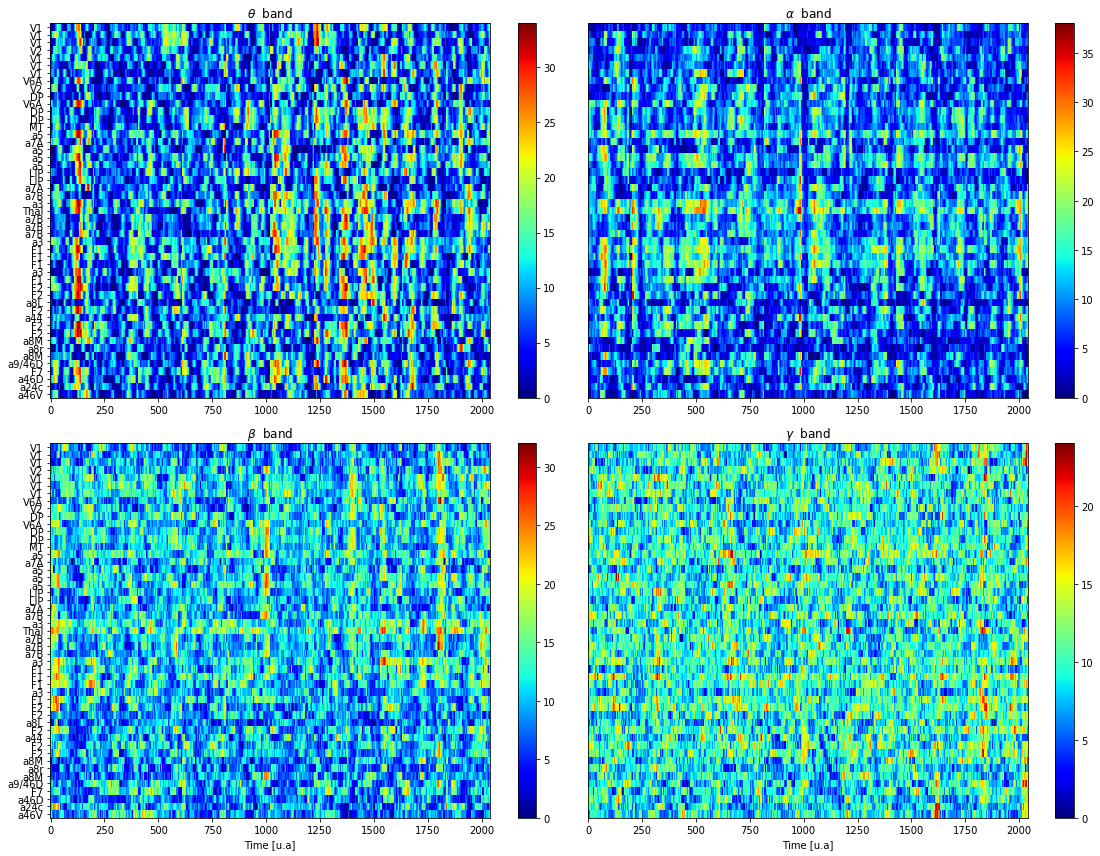

In [19]:
plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
plt.imshow(dg_delta[:,:10*len(net.tarray)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.yticks(range(49), net.session_info['areas'])
plt.title(r'$\theta$  band')
plt.subplot(2,2,2)
plt.imshow(dg_alpha[:,:10*len(net.tarray)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.title(r'$\alpha$  band')
plt.yticks([])
plt.subplot(2,2,3)
plt.imshow(dg_beta[:,:10*len(net.tarray)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.title(r'$\beta$  band')
plt.yticks(range(49), net.session_info['areas'])
plt.xlabel('Time [u.a]')
plt.subplot(2,2,4)
plt.imshow(dg_gamma[:,:10*len(net.tarray)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.yticks([])
plt.title(r'$\gamma$  band')
plt.xlabel('Time [u.a]')
plt.tight_layout()
plt.savefig('figures/layerwise_net/strength_raster.png')

It is hard to compare both the weighted and binary version of the measure by means of the raster plot, however we can measure the summed strength/degree of the network for a more general view. Let's plot the summed node strength/degree for the alpha band, as well as the summed node strength/degree over trials for both weighted (blue plots) and binary (red plots) network.

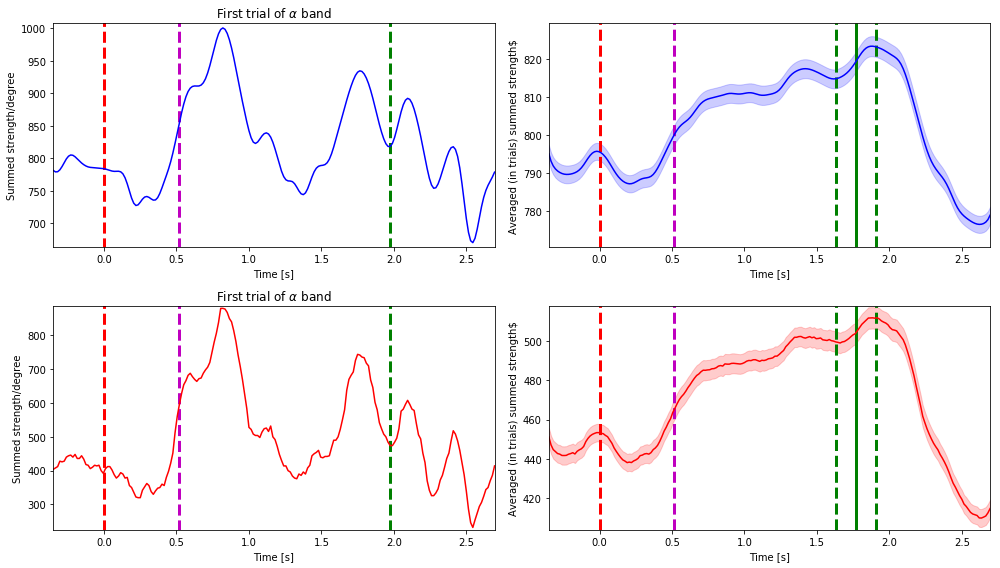

In [33]:
plt.figure(figsize=(14,8))
for i in range(2):
    if i == 0:
        c = 'b'
    else:
        c = 'r'
    p1 = 1 + i*2
    p2 = 2 + i*2
    plt.subplot(2,2,p1)
    if i == 0:
        s_d_w = st_alpha[:,:len(net.tarray)].sum(axis = 0)
    else:
        s_d_w = dg_alpha[:,:len(net.tarray)].sum(axis = 0)
    plt.plot(net.tarray, s_d_w, color = c)
    plt.ylim([s_d_w.min()-7, s_d_w.max()+7])
    plt.xlim([net.tarray[0],net.tarray[-1]])
    plt.vlines(0, s_d_w.min()-10, s_d_w.max()+10, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off'][0]-net.session_info['t_cue_on'][0])/1000, 
               s_d_w.min()-10, s_d_w.max()+10, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on'][0]-net.session_info['t_cue_on'][0])/1000, 
               s_d_w.min()-10, s_d_w.max()+10, linestyle='--', linewidth = 3, color = 'g')
    plt.title(r'First trial of $\alpha$ band')
    plt.xlabel('Time [s]')
    plt.ylabel('Summed strength/degree')
    plt.subplot(2,2,p2)
    if i == 0:
        s_d = st_alpha.sum(axis=0)
    else:
        s_d = dg_alpha.sum(axis=0)
    s_d = s_d.reshape(540,len(net.tarray))
    s_d_m = s_d.mean(axis = 0)
    s_d_e = s_d.std(axis = 0) / (s_d.shape[0]**0.5)
    s_d_m = s_d_m
    s_d_e = s_d_e
    plt.plot(net.tarray, s_d_m, color = c)
    plt.fill_between(net.tarray, s_d_m-s_d_e, s_d_m+s_d_e, alpha = .2, color = c)
    #plt.imshow(s_d[:,10:-10], aspect = 'auto', cmap = 'viridis', origin = 'lower', extent=[-0.65,3,1,540])
    #plt.colorbar()
    plt.xlim([net.tarray[0],net.tarray[-1]])
    plt.ylim([s_d_m.min()-6, s_d_m.max()+6])
    plt.vlines(0, s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
               s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='-', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'g')
    plt.ylabel('Averaged (in trials) summed strength$')
    plt.xlabel('Time [s]')
plt.tight_layout()
plt.savefig('figures/layerwise_net/summed_strength_alpha.png')

Next, we can analyside the summed strength avareged on trials for each frequency band as well:

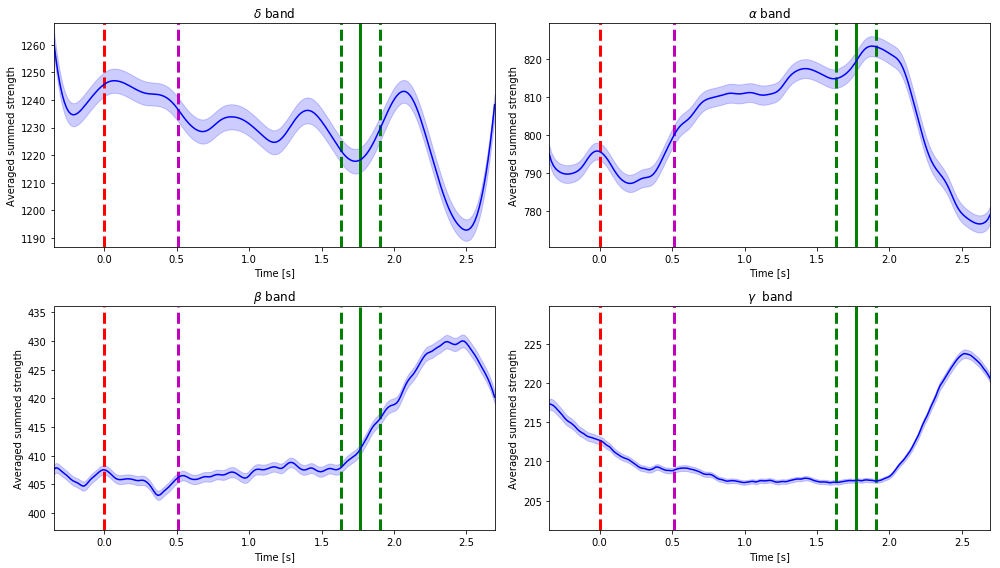

In [34]:
plt.figure(figsize=(14,8))
c = ['b', 'r']
for j in range( len(net.bands) ):
    plt.subplot(2,2,j+1)
    if j == 0: s_d = st_delta.sum(axis=0)
    if j == 1: s_d = st_alpha.sum(axis=0)
    if j == 2: s_d = st_beta.sum(axis=0)
    if j == 3: s_d = st_gamma.sum(axis=0)
    s_d = s_d.reshape(540,len(net.tarray))
    s_d_m = s_d.mean(axis = 0)
    s_d_e = s_d.std(axis = 0) / (s_d.shape[0]**0.5)
    plt.plot(net.tarray, s_d_m, color = 'b')
    plt.fill_between(net.tarray, s_d_m-s_d_e, s_d_m+s_d_e, alpha = .2, color = 'b')
    plt.title(bands[j] + ' band')
    plt.xlim([net.tarray[0],net.tarray[-1]])
    plt.ylim([s_d_m.min()-6, s_d_m.max()+6])
    plt.vlines(0, s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                   s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='-', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'g')
    plt.ylabel('Averaged summed strength')
    plt.xlabel('Time [s]')
plt.tight_layout()
plt.savefig('figures/layerwise_net/summed_strength_bands.png')

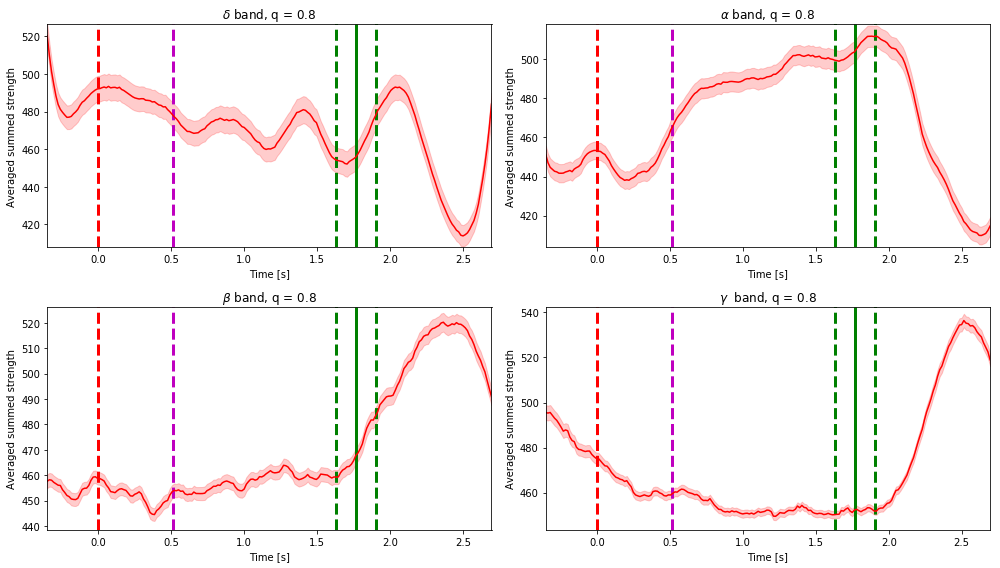

In [36]:
plt.figure(figsize=(14,8))
c = ['b', 'r']
for j in range( len(net.bands) ):
    plt.subplot(2,2,j+1)
    if j == 0: s_d = dg_delta.sum(axis=0)
    if j == 1: s_d = dg_alpha.sum(axis=0)
    if j == 2: s_d = dg_beta.sum(axis=0)
    if j == 3: s_d = dg_gamma.sum(axis=0)
    s_d = s_d.reshape(540,len(net.tarray))
    s_d_m = s_d.mean(axis = 0)
    s_d_e = s_d.std(axis = 0) / (s_d.shape[0]**0.5)
    plt.plot(net.tarray, s_d_m, color = 'r')
    plt.fill_between(net.tarray, s_d_m-s_d_e, s_d_m+s_d_e, alpha = .2, color='r')
    plt.title(bands[j] + ' band, q = 0.8')
    plt.xlim([net.tarray[0],net.tarray[-1]])
    plt.ylim([s_d_m.min()-6, s_d_m.max()+6])
    plt.vlines(0, s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                   s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='-', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+8, linestyle='--', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+8, linestyle='--', linewidth = 3, color = 'g')
    plt.ylabel('Averaged summed strength')
    plt.xlabel('Time [s]')
plt.tight_layout()
plt.savefig('figures/layerwise_net/summed_degree_bands.png')

Last but not least, we can instead of average over all trials take the average by trials that the same cue was applied:

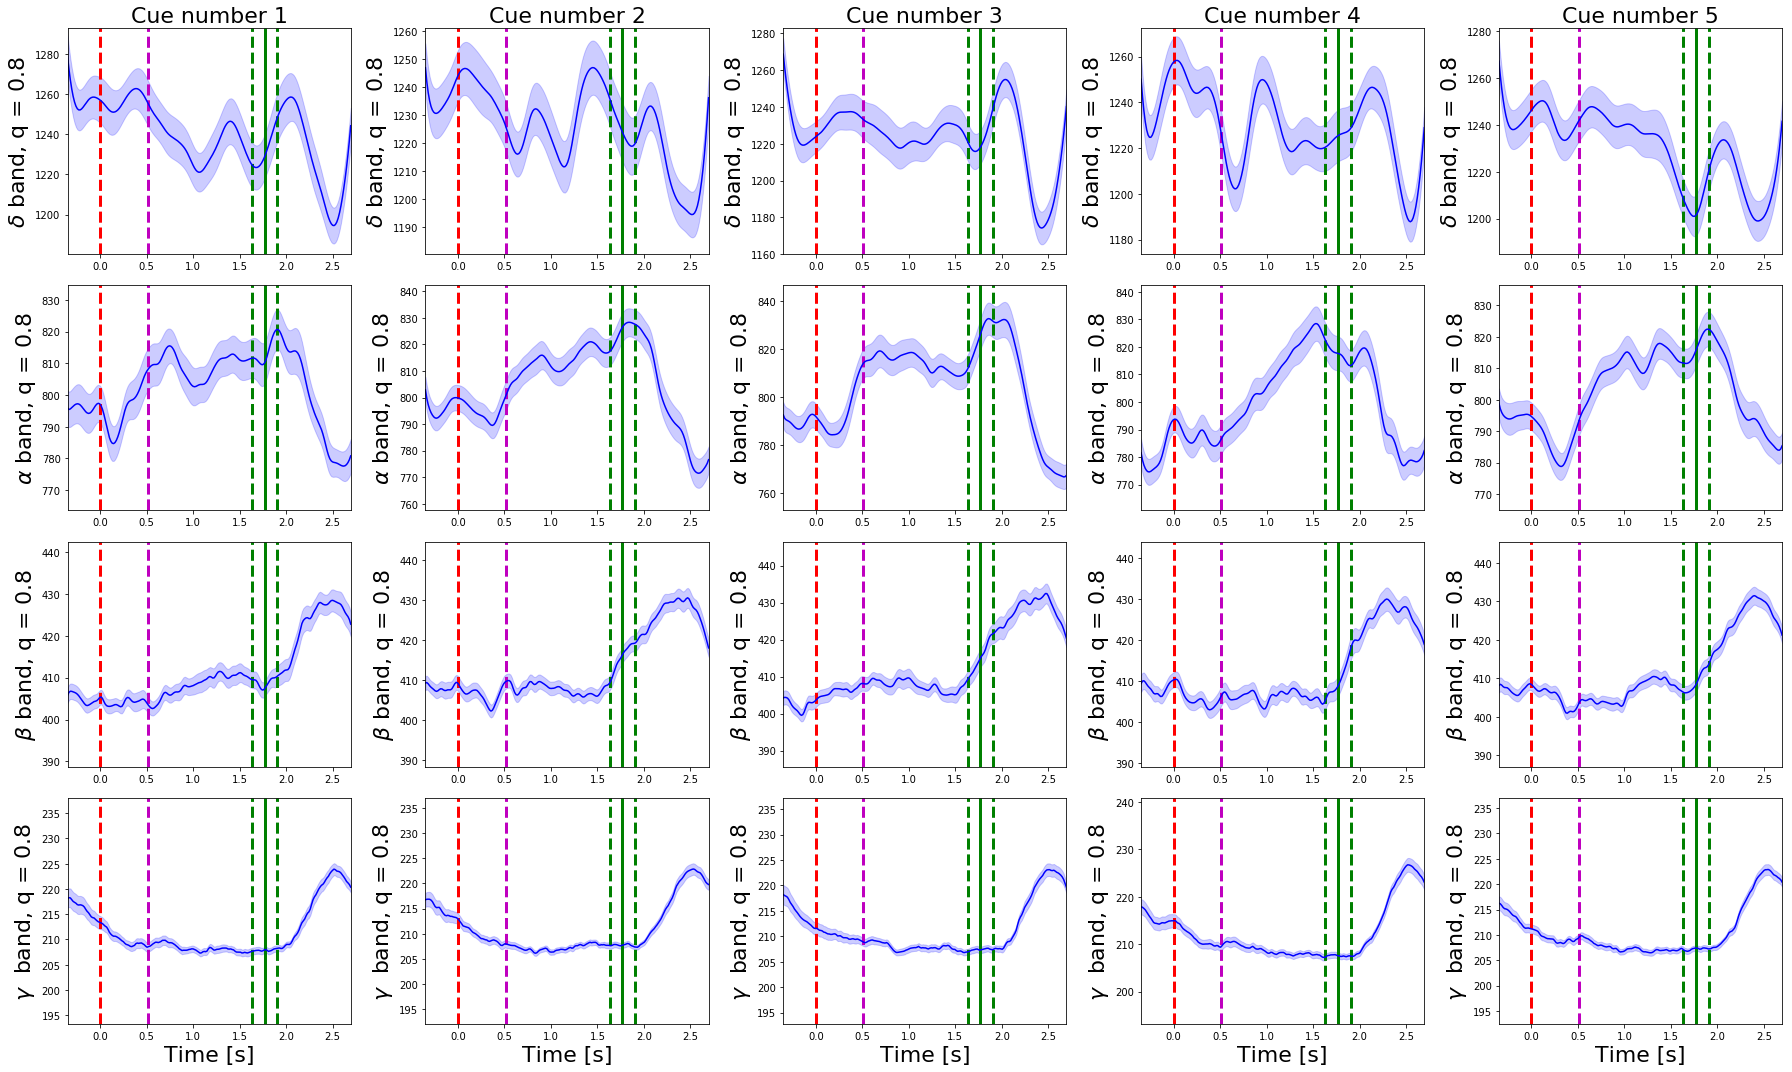

In [37]:
idx = 1
plt.figure(figsize=(25,15))
for i in range( len(net.bands) ):
    for j in range( net.stim_grid.shape[0] ):
        # Computing average over trials for specific cue number
        nt  = np.sum(net.session_info['stim']==j)
        if i == 0: s_d = st_delta.sum(axis=0)
        if i == 1: s_d = st_alpha.sum(axis=0)
        if i == 2: s_d = st_beta.sum(axis=0)
        if i == 3: s_d = st_gamma.sum(axis=0)
        s_d = s_d[net.stim_grid[j].astype(bool)].reshape(nt, len(net.tarray))
        s_d_m = s_d.mean(axis = 0)
        s_d_e = s_d.std(axis = 0) / (s_d.shape[0]**0.5)
        # plot
        plt.subplot( len(net.bands), net.stim_grid.shape[0], idx)
        plt.plot(net.tarray, s_d_m, color = 'b')
        plt.fill_between(net.tarray, s_d_m-s_d_e, s_d_m+s_d_e, alpha = .2, color='b')
        plt.xlim([net.tarray[0],net.tarray[-1]])
        plt.ylim([s_d_m.min()-14, s_d_m.max()+14])
        plt.vlines(0, s_d_m.min()-14, s_d_m.max()+14, linestyle='--', linewidth = 3, color = 'r')
        plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                   s_d_m.min()-14, s_d_m.max()+14, linestyle='--', linewidth = 3, color = 'm')
        plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-14, s_d_m.max()+14, linestyle='-', linewidth = 3, color = 'g')
        plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-14, s_d_m.max()+14, linestyle='--', linewidth = 3, color = 'g')
        plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-14, s_d_m.max()+14, linestyle='--', linewidth = 3, color = 'g')
        plt.ylabel(bands[i] + ' band, q = 0.8', fontsize=22)
        idx += 1
        if i == 0:
            plt.title('Cue number ' + str(j+1), fontsize=22)
        if i == 3:
            plt.xlabel('Time [s]', fontsize=22)
plt.tight_layout()
plt.savefig('figures/layerwise_net/summed_degree_bands_cue.png')

### Correlation between strength and degree as a function of threshold

In [28]:
cc_ns = np.zeros([len(q_list), len(net.bands) ])
for i in tqdm (range( len(q_list) )):
    net.compute_coherence_thresholds(q = q_list[i])
    for j in range( len(net.bands) ):
        # Degree
        net.compute_nodes_degree(j, thr = net.coh_thr[j])
        # Strength
        #net.compute_nodes_degree(j, thr = None)
        strength   = net.node_degree[0,:,j,:].sum(axis=0)
        degree     = net.node_degree[1,:,j,:].sum(axis=0)
        cc_ns[i,j] = np.corrcoef(strength, degree)[0,1]

100%|██████████| 10/10 [10:24<00:00, 62.43s/it]


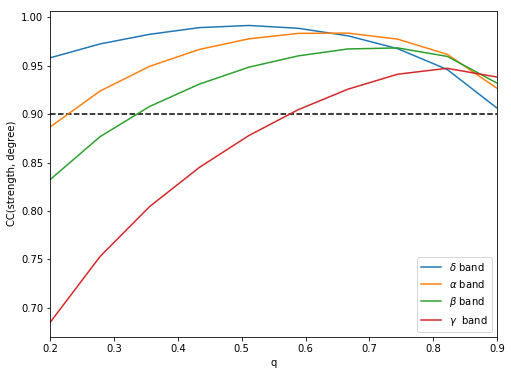

In [29]:
plt.figure(figsize=(8,6))
for j in range( len(net.bands) ):
    plt.plot(q_list, cc_ns[:,j], label = bands[j] + ' band')
    plt.ylabel('CC(strength, degree)')
    plt.xlabel('q')
plt.xlim([0.2,0.9])
plt.hlines(0.90,0.2,0.9, linestyle = '--', color = 'k')
plt.legend()

In [60]:
# Put threshold back to q = 0.8
net.compute_coherence_thresholds(q = 0.8)

### Coreness 

The analysis below are all done for the binary network. First, we can do the same analysis measuring the k-coreness of the each node:

In [27]:
net.create_null_model(randomize='edges')
kc_delta = net.compute_nodes_coreness(band=0, thr=net.coh_thr[0], use='igraph', on_null = False)
kc_alpha = net.compute_nodes_coreness(band=1, thr=net.coh_thr[1], use='igraph', on_null = False)
kc_beta  = net.compute_nodes_coreness(band=2, thr=net.coh_thr[2], use='igraph', on_null = False)
kc_gamma = net.compute_nodes_coreness(band=3, thr=net.coh_thr[3], use='igraph', on_null = False)

100%|██████████| 110160/110160 [01:34<00:00, 1165.88it/s]


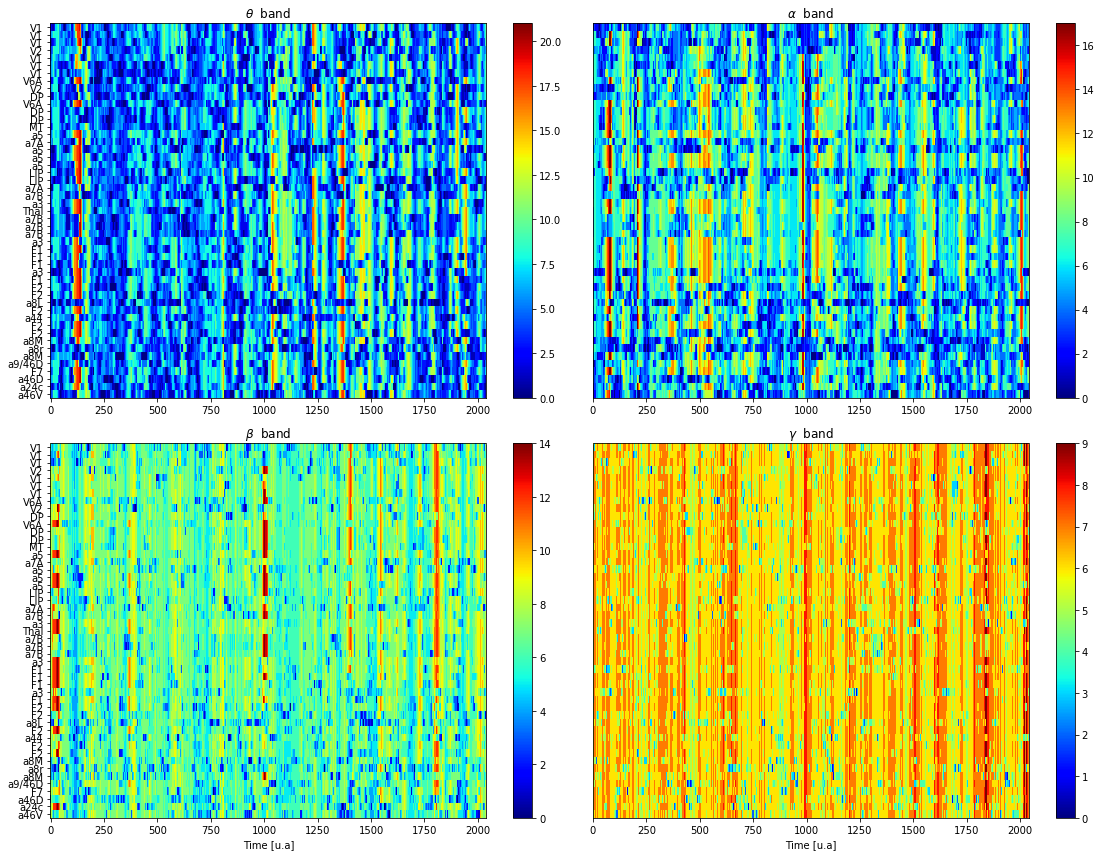

In [28]:
plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
plt.imshow(kc_delta[:,:10*len(net.tarray)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.yticks(range(49), net.session_info['areas'])
plt.title(r'$\theta$  band')
plt.subplot(2,2,2)
plt.imshow(kc_alpha[:,:10*len(net.tarray)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.yticks([])
plt.title(r'$\alpha$  band')
plt.subplot(2,2,3)
plt.imshow(kc_beta[:,:10*len(net.tarray)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.yticks(range(49), net.session_info['areas'])
plt.title(r'$\beta$  band')
plt.xlabel('Time [u.a]')
plt.subplot(2,2,4)
plt.imshow(kc_gamma[:,:10*len(net.tarray)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.yticks([])
plt.title(r'$\gamma$  band')
plt.xlabel('Time [u.a]')
plt.tight_layout()
plt.savefig('figures/layerwise_net/raster_coreness.png')

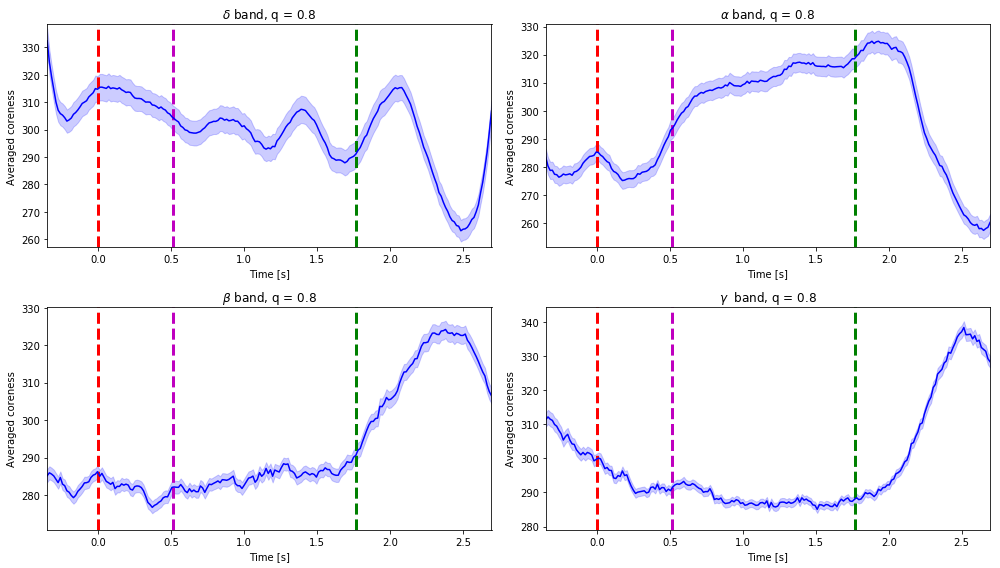

In [29]:
plt.figure(figsize=(14,8))
for j in range( len(net.bands) ):
    plt.subplot(2,2,j+1)
    if j == 0: s_d = kc_delta.sum(axis=0)
    if j == 1: s_d = kc_alpha.sum(axis=0)
    if j == 2: s_d = kc_beta.sum(axis=0)
    if j == 3: s_d = kc_gamma.sum(axis=0)
    #s_d = net.coreness[1,:,j,:].sum(axis=0)
    s_d = s_d.reshape(540,len(net.tarray))
    s_d_m = s_d.mean(axis = 0)
    s_d_e = s_d.std(axis = 0) / (s_d.shape[0]**0.5)
    plt.plot(net.tarray, s_d_m, color = 'b')
    plt.fill_between(net.tarray, s_d_m-s_d_e, s_d_m+s_d_e, color = 'b', alpha = .2)
    plt.title(bands[j] + ' band, q = 0.8')
    plt.xlim([net.tarray[0],net.tarray[-1]])
    plt.ylim([s_d_m.min()-6, s_d_m.max()+6])
    plt.vlines(0, s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='-', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+8, linestyle='--', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+8, linestyle='--', linewidth = 3, color = 'g')
    plt.ylabel('Averaged coreness')
    plt.xlabel('Time [s]')
plt.tight_layout()
plt.savefig('figures/layerwise_net/summed_coreness_alpha.png')

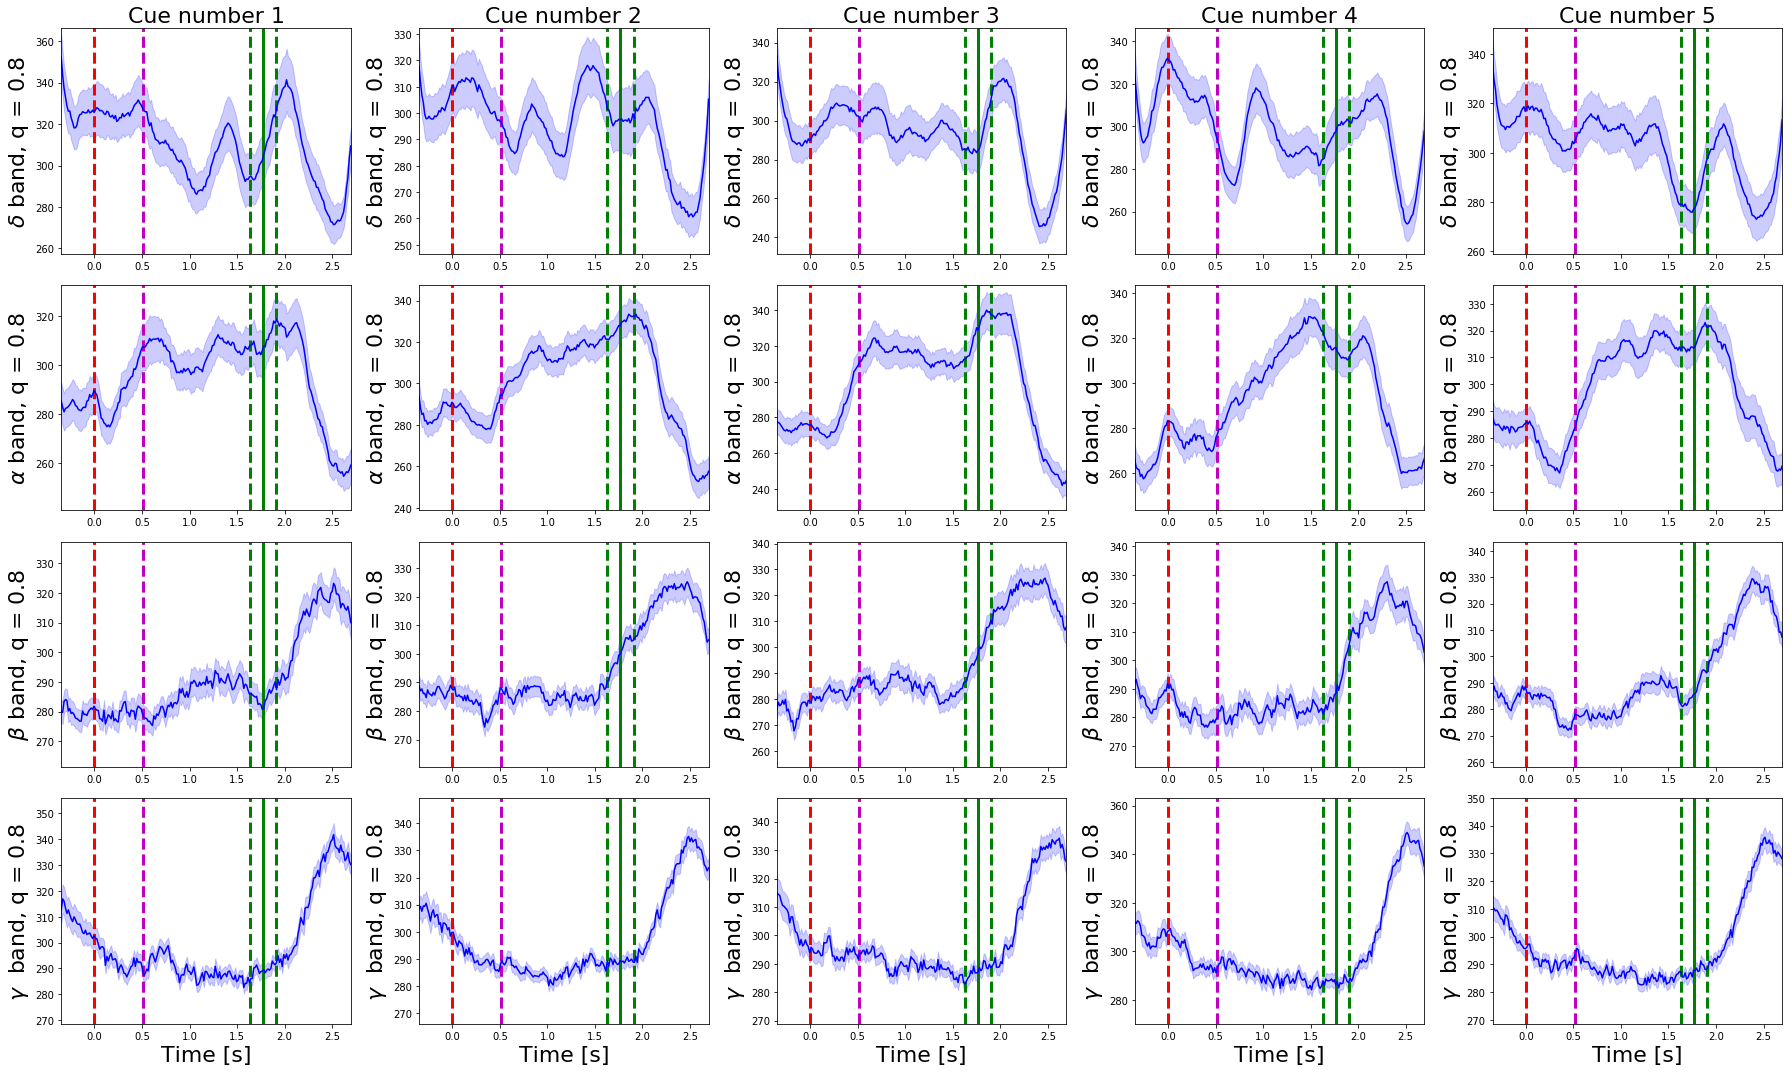

In [22]:
idx = 1
plt.figure(figsize=(25,15))
for i in range( len(net.bands) ):
    for j in range( net.stim_grid.shape[0] ):
        # Computing average over trials for specific cue number
        nt  = np.sum(net.session_info['stim']==j)
        if i == 0: s_d = kc_delta.sum(axis=0)
        if i == 1: s_d = kc_alpha.sum(axis=0)
        if i == 2: s_d = kc_beta.sum(axis=0)
        if i == 3: s_d = kc_gamma.sum(axis=0)
        #s_d = net.coreness[1,:,i,:].sum(axis=0)
        s_d = s_d[net.stim_grid[j].astype(bool)].reshape(nt, len(net.tarray))
        s_d_m = s_d.mean(axis = 0)
        s_d_e = s_d.std(axis = 0) / (s_d.shape[0]**0.5)
        # plot
        plt.subplot( len(net.bands), net.stim_grid.shape[0], idx)
        plt.plot(net.tarray, s_d_m, color = 'b')
        plt.fill_between(net.tarray, s_d_m-s_d_e, s_d_m+s_d_e, color = 'b', alpha = .2)
        plt.xlim([net.tarray[0],net.tarray[-1]])
        plt.ylim([s_d_m.min()-14, s_d_m.max()+14])
        plt.vlines(0, s_d_m.min()-14, s_d_m.max()+14, linestyle='--', linewidth = 3, color = 'r')
        plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                   s_d_m.min()-14, s_d_m.max()+14, linestyle='--', linewidth = 3, color = 'm')
        plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-14, s_d_m.max()+14, linestyle='-', linewidth = 3, color = 'g')
        plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-14, s_d_m.max()+14, linestyle='--', linewidth = 3, color = 'g')
        plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-14, s_d_m.max()+14, linestyle='--', linewidth = 3, color = 'g')
        plt.ylabel(bands[i] + ' band, q = 0.8', fontsize=22)
        idx += 1
        if i == 0:
            plt.title('Cue number ' + str(j+1), fontsize=22)
        if i == 3:
            plt.xlabel('Time [s]', fontsize=22)
plt.tight_layout()
plt.savefig('figures/layerwise_net/summed_coreness_bands_cue.png')

### Clustering

Next we compute the clustering coefficient.

In [16]:
cl_delta = net.compute_nodes_clustering(band=0, thr=net.coh_thr[0], use='igraph')
cl_alpha = net.compute_nodes_clustering(band=1, thr=net.coh_thr[1], use='igraph')
cl_beta  = net.compute_nodes_clustering(band=2, thr=net.coh_thr[2], use='igraph')
cl_gamma = net.compute_nodes_clustering(band=3, thr=net.coh_thr[3], use='igraph')

100%|██████████| 110160/110160 [01:31<00:00, 1199.11it/s]


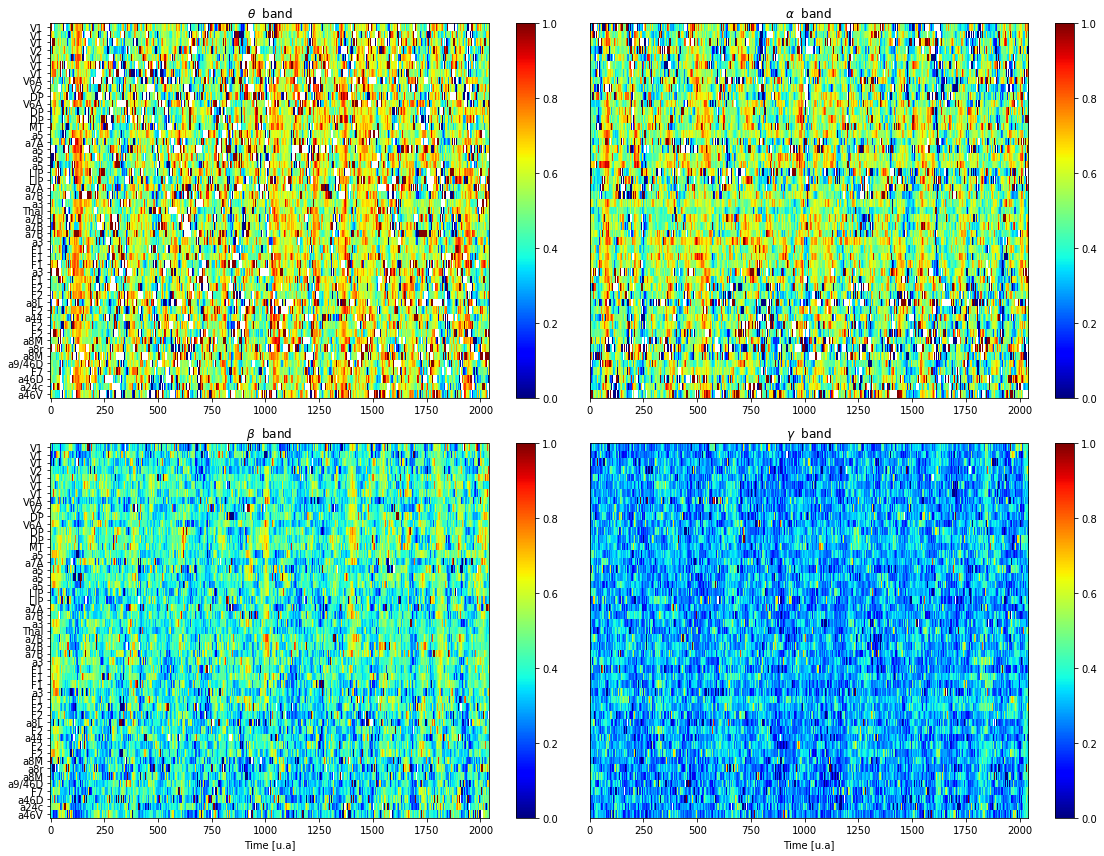

In [18]:
plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
plt.imshow(cl_delta[:,:10*len(net.tarray)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.yticks(range(49), net.session_info['areas'])
plt.title(r'$\theta$  band')
plt.subplot(2,2,2)
plt.imshow(cl_alpha[:,:10*len(net.tarray)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.yticks([])
plt.title(r'$\alpha$  band')
plt.subplot(2,2,3)
plt.imshow(cl_beta[:,:10*len(net.tarray)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.yticks(range(49), net.session_info['areas'])
plt.title(r'$\beta$  band')
plt.xlabel('Time [u.a]')
plt.subplot(2,2,4)
plt.imshow(cl_gamma[:,:10*len(net.tarray)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.yticks([])
plt.title(r'$\gamma$  band')
plt.xlabel('Time [u.a]')
plt.tight_layout()
plt.savefig('figures/layerwise_net/raster_clustering.png')

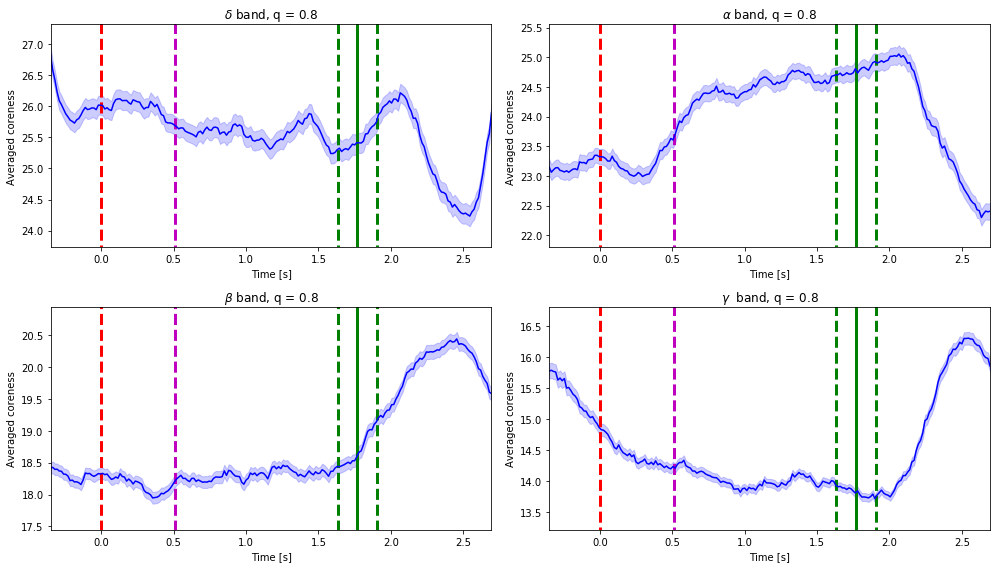

In [22]:
plt.figure(figsize=(14,8))
for j in range( len(net.bands) ):
    plt.subplot(2,2,j+1)
    if j == 0: s_d = np.nan_to_num(cl_delta).sum(axis=0)
    if j == 1: s_d = np.nan_to_num(cl_alpha).sum(axis=0)
    if j == 2: s_d = np.nan_to_num(cl_beta).sum(axis=0)
    if j == 3: s_d = np.nan_to_num(cl_gamma).sum(axis=0)
    #s_d = net.coreness[1,:,j,:].sum(axis=0)
    s_d = s_d.reshape(540,len(net.tarray))
    s_d_m = s_d.mean(axis = 0)
    s_d_e = s_d.std(axis = 0) / (s_d.shape[0]**0.5)
    plt.plot(net.tarray, s_d_m, color = 'b')
    plt.fill_between(net.tarray, s_d_m-s_d_e, s_d_m+s_d_e, color = 'b', alpha = .2)
    plt.title(bands[j] + ' band, q = 0.8')
    plt.xlim([net.tarray[0],net.tarray[-1]])
    plt.ylim([s_d_m.min()-0.5, s_d_m.max()+.5])
    plt.vlines(0, s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='-', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+8, linestyle='--', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+8, linestyle='--', linewidth = 3, color = 'g')
    plt.ylabel('Averaged coreness')
    plt.xlabel('Time [s]')
plt.tight_layout()
plt.savefig('figures/layerwise_net/summed_clustering.png')

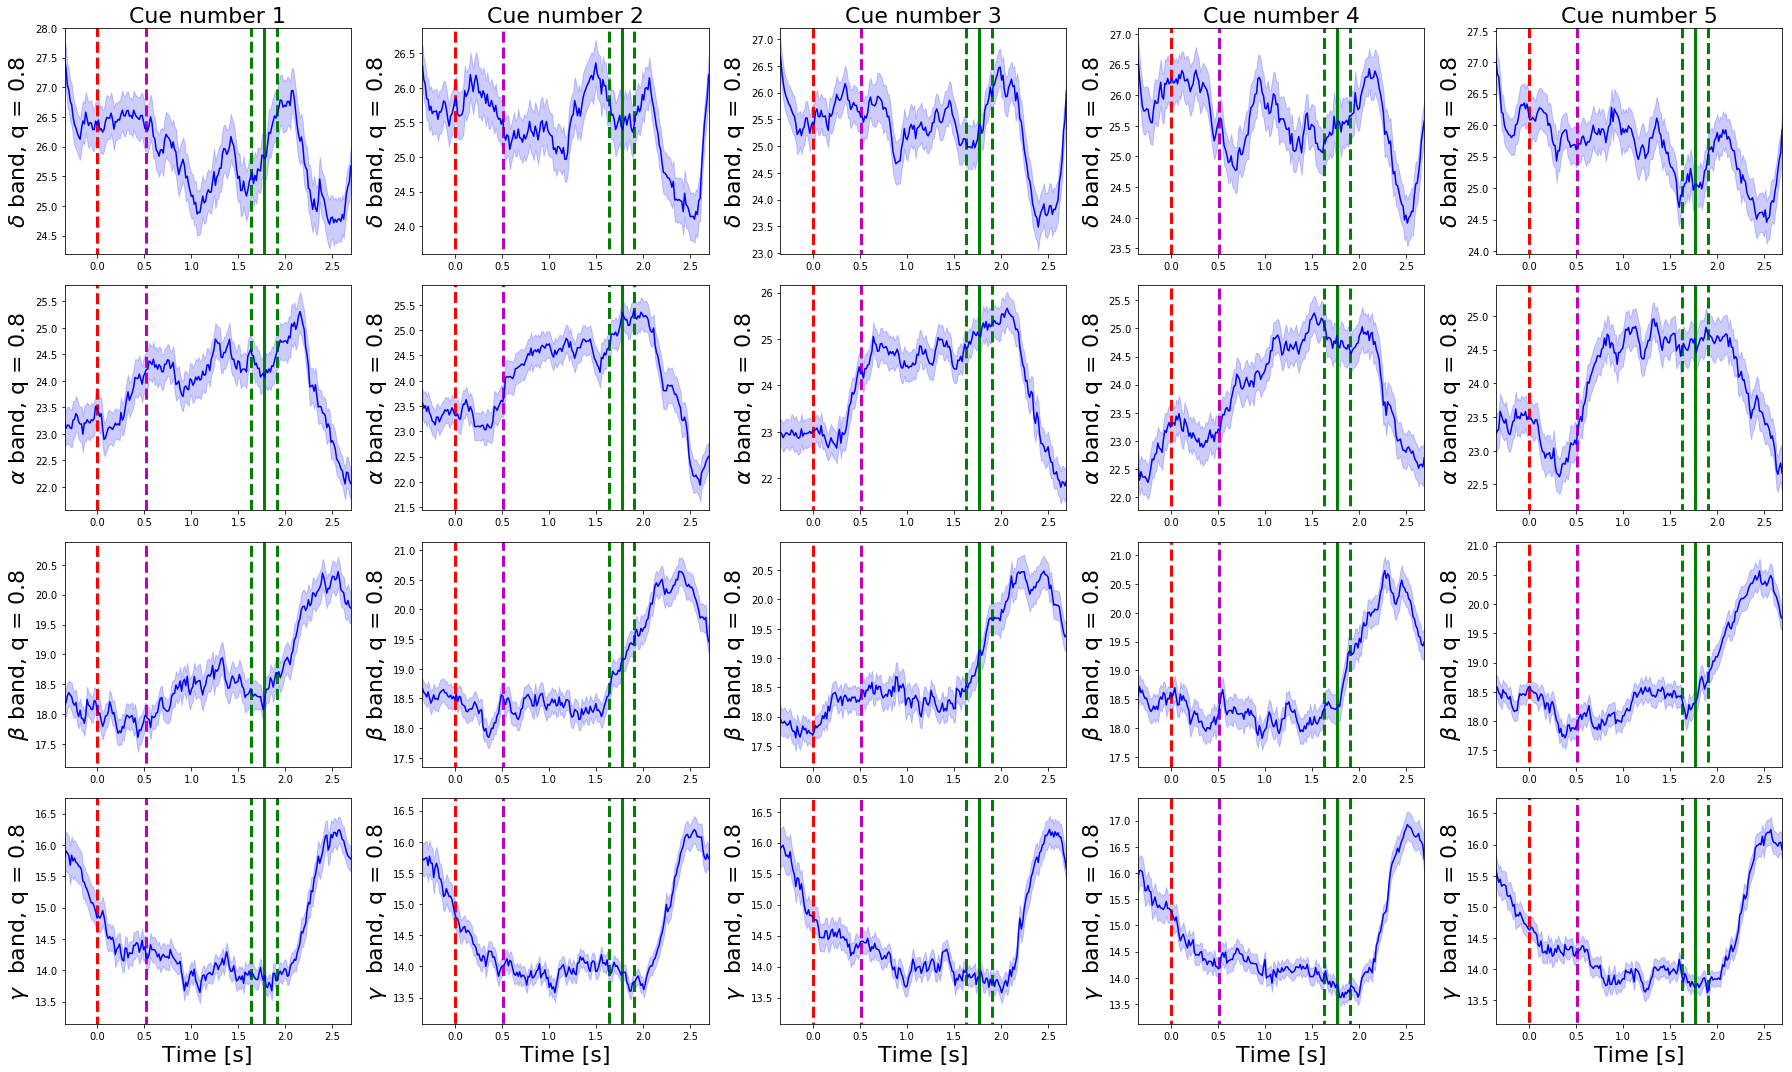

In [24]:
idx = 1
plt.figure(figsize=(25,15))
for i in range( len(net.bands) ):
    for j in range( net.stim_grid.shape[0] ):
        # Computing average over trials for specific cue number
        nt  = np.sum(net.session_info['stim']==j)
        if i == 0: s_d = np.nan_to_num(cl_delta).sum(axis=0)
        if i == 1: s_d = np.nan_to_num(cl_alpha).sum(axis=0)
        if i == 2: s_d = np.nan_to_num(cl_beta).sum(axis=0)
        if i == 3: s_d = np.nan_to_num(cl_gamma).sum(axis=0)
        #s_d = net.coreness[1,:,i,:].sum(axis=0)
        s_d = s_d[net.stim_grid[j].astype(bool)].reshape(nt, len(net.tarray))
        s_d_m = s_d.mean(axis = 0)
        s_d_e = s_d.std(axis = 0) / (s_d.shape[0]**0.5)
        # plot
        plt.subplot( len(net.bands), net.stim_grid.shape[0], idx)
        plt.plot(net.tarray, s_d_m, color = 'b')
        plt.fill_between(net.tarray, s_d_m-s_d_e, s_d_m+s_d_e, color = 'b', alpha = .2)
        plt.xlim([net.tarray[0],net.tarray[-1]])
        plt.ylim([s_d_m.min()-.5, s_d_m.max()+.5])
        plt.vlines(0, s_d_m.min()-14, s_d_m.max()+14, linestyle='--', linewidth = 3, color = 'r')
        plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                   s_d_m.min()-14, s_d_m.max()+14, linestyle='--', linewidth = 3, color = 'm')
        plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-14, s_d_m.max()+14, linestyle='-', linewidth = 3, color = 'g')
        plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-14, s_d_m.max()+14, linestyle='--', linewidth = 3, color = 'g')
        plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-14, s_d_m.max()+14, linestyle='--', linewidth = 3, color = 'g')
        plt.ylabel(bands[i] + ' band, q = 0.8', fontsize=22)
        idx += 1
        if i == 0:
            plt.title('Cue number ' + str(j+1), fontsize=22)
        if i == 3:
            plt.xlabel('Time [s]', fontsize=22)
plt.tight_layout()
plt.savefig('figures/layerwise_net/summed_clustering_bands_cue.png')

### Modularity

In [19]:
m_delta = net.compute_network_modularity(band=0, thr=net.coh_thr[0], use='igraph')
m_alpha = net.compute_network_modularity(band=1, thr=net.coh_thr[1], use='igraph')
m_beta  = net.compute_network_modularity(band=2, thr=net.coh_thr[2], use='igraph')
m_gamma = net.compute_network_modularity(band=3, thr=net.coh_thr[3], use='igraph')

100%|██████████| 110160/110160 [02:32<00:00, 723.21it/s]


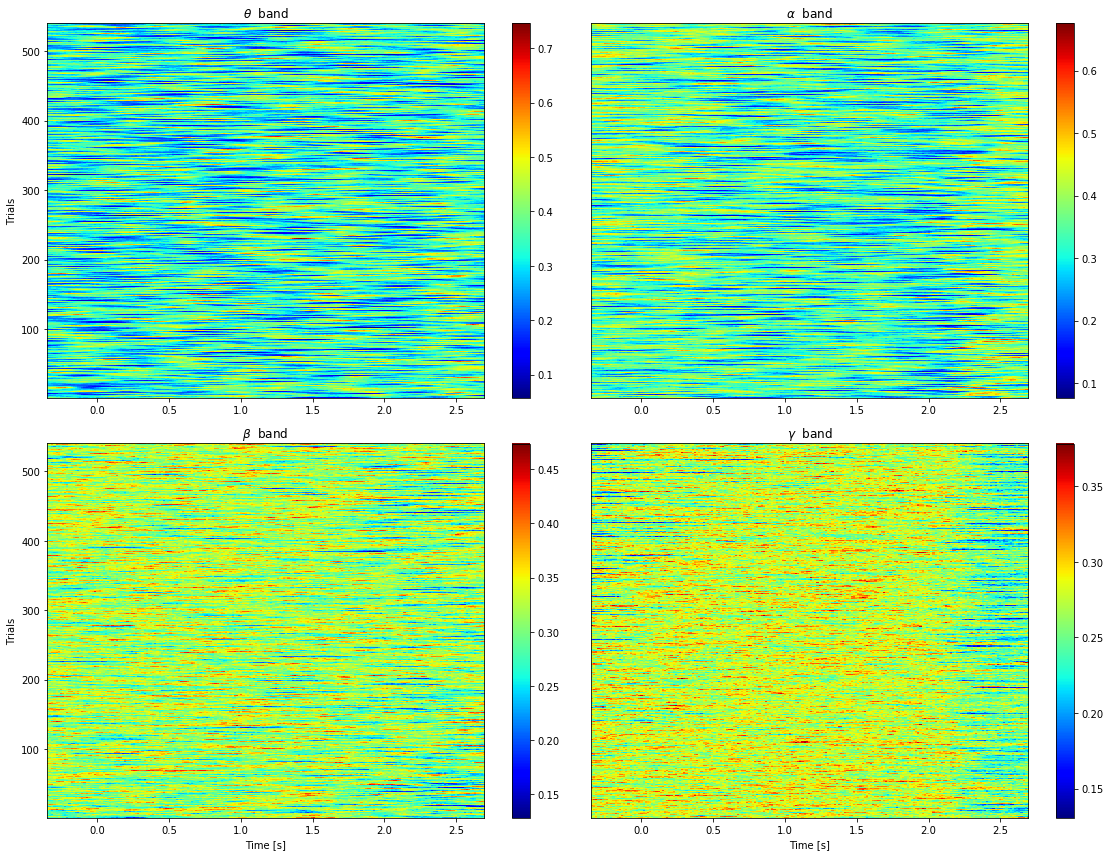

In [23]:
plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
plt.imshow(m_delta.reshape([540, len(net.tarray)]), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[net.tarray[0], net.tarray[-1], 1, 540]); plt.colorbar()
plt.ylabel('Trials')
plt.title(r'$\theta$  band')
plt.subplot(2,2,2)
plt.imshow(m_alpha.reshape([540, len(net.tarray)]), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[net.tarray[0], net.tarray[-1], 1, 540]); plt.colorbar()
plt.yticks([])
plt.title(r'$\alpha$  band')
plt.subplot(2,2,3)
plt.imshow(m_beta.reshape([540, len(net.tarray)]), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[net.tarray[0], net.tarray[-1], 1, 540]); plt.colorbar()
plt.title(r'$\beta$  band')
plt.ylabel('Trials')
plt.xlabel('Time [s]')
plt.subplot(2,2,4)
plt.imshow(m_gamma.reshape([540, len(net.tarray)]), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[net.tarray[0], net.tarray[-1], 1, 540]); plt.colorbar()
plt.yticks([])
plt.title(r'$\gamma$  band')
plt.xlabel('Time [s]')
plt.tight_layout()
plt.savefig('figures/layerwise_net/raster_modularity.png')

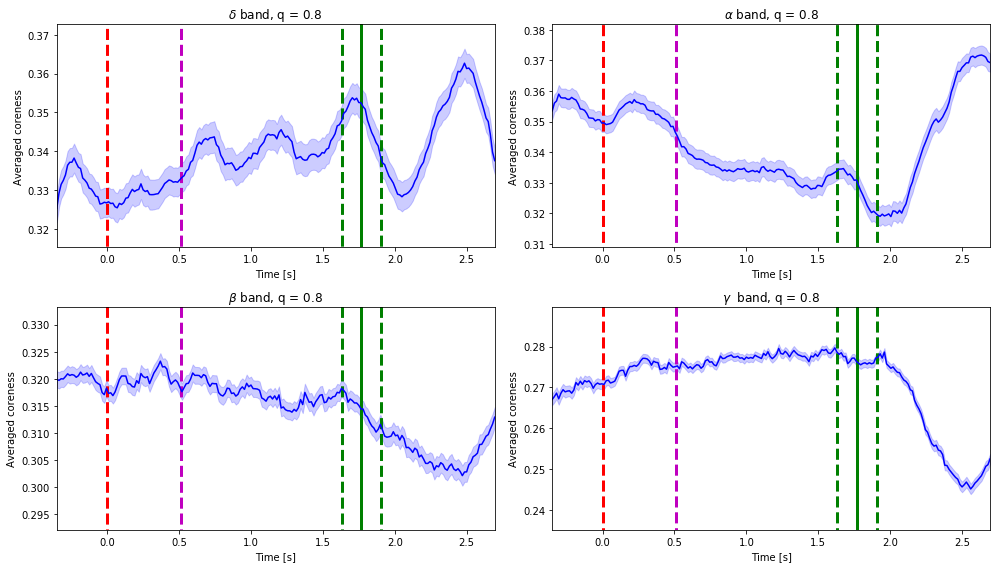

In [28]:
plt.figure(figsize=(14,8))
for j in range( len(net.bands) ):
    plt.subplot(2,2,j+1)
    if j == 0: s_d = m_delta
    if j == 1: s_d = m_alpha
    if j == 2: s_d = m_beta
    if j == 3: s_d = m_gamma
    #s_d = net.coreness[1,:,j,:].sum(axis=0)
    s_d = s_d.reshape(540,len(net.tarray))
    s_d_m = s_d.mean(axis = 0)
    s_d_e = s_d.std(axis = 0) / (s_d.shape[0]**0.5)
    plt.plot(net.tarray, s_d_m, color = 'b')
    plt.fill_between(net.tarray, s_d_m-s_d_e, s_d_m+s_d_e, color = 'b', alpha = .2)
    plt.title(bands[j] + ' band, q = 0.8')
    plt.xlim([net.tarray[0],net.tarray[-1]])
    plt.ylim([s_d_m.min()-0.01, s_d_m.max()+.01])
    plt.vlines(0, s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='-', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+8, linestyle='--', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+8, linestyle='--', linewidth = 3, color = 'g')
    plt.ylabel('Averaged coreness')
    plt.xlabel('Time [s]')
plt.tight_layout()
plt.savefig('figures/layerwise_net/summed_modularity.png')

### Saving snapshots to produce gifs

The cell bellow saves the measures above for each trial (in the alpha band) in order to produce a GIF with the maps later.

In [29]:
plt.figure(figsize=(12,8))
for i in tqdm( range(net.session_info['nT']) ):
    plt.figure()
    plt.imshow(st_alpha[:,i*244:(i+1)*244], aspect = 'auto', cmap = 'jet', origin = 'lower', vmax=15, extent=[-0.65,3.00,0,48]); plt.colorbar()
    plt.vlines(0, 0, 48, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'g')
    plt.yticks(range(49), net.session_info['areas'])
    plt.title('Trial = ' + str(i+1))
    plt.savefig('figures/st_alpha'+str(i)+'.png')
    plt.close()

  0%|          | 0/540 [00:00<?, ?it/s]


NameError: name 'st_alpha' is not defined

<Figure size 864x576 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(12,8))
for i in tqdm( range(net.session_info['nT']) ):
    plt.figure()
    plt.imshow(kc_alpha[:,i*244:(i+1)*244], aspect = 'auto', cmap = 'jet', origin = 'lower', vmax=15, extent=[-0.65,3.00,0,48]); plt.colorbar()
    plt.vlines(0, 0, 48, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'g')
    plt.yticks(range(49), net.session_info['areas'])
    plt.title('Trial = ' + str(i+1) + ', threshold = 0.7')
    plt.savefig('figures/core_alpha_'+str(i)+'.png')
    plt.close()

In [ ]:
plt.figure(figsize=(12,8))
for i in tqdm( range(net.session_info['nT']) ):
    plt.figure()
    plt.imshow(cl_alpha[:,i*244:(i+1)*244], aspect = 'auto', cmap = 'jet', origin = 'lower', vmax=1, extent=[-0.65,3.00,0,48]); plt.colorbar()
    plt.vlines(0, 0, 48, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'g')
    plt.yticks(range(49), net.session_info['areas'])
    plt.title('Trial = ' + str(i+1) + ', threshold = ' + str(net.coh_thr['1']))
    plt.savefig('figures/clustering_alpha_'+str(i)+'.png')
    plt.close()

In [ ]:
w

### Plotting on the brain sketch

In [18]:
from GDa.graphics.plot_brain_sketch import plot_node_brain_sketch, plot_edge_brain_sketch

In [19]:
#for i in range(244):
#    plt.figure()
#    plot_node_brain_sketch(net.session_info['channels_labels'].astype(int), net.A[:,0,i])

In [21]:
# Brain nets

for i in tqdm( range(net.tarray.shape[0]) ):
    if net.tarray[i] < 0:
        color = 'r'
        title = 'Baseline'
    if net.tarray[i] >= 0 and net.tarray[i] < (net.session_info['t_cue_off'][0]-net.session_info['t_cue_on'][0])/1000:
        color = 'b'
        title = 'Cue'
    if net.tarray[i] >= (net.session_info['t_cue_off'][0]-net.session_info['t_cue_on'][0])/1000 and net.tarray[i] < (net.session_info['t_match_on'][0]-net.session_info['t_cue_on'][0])/1000:
        color = 'm'
        title = 'Delay'
    if net.tarray[i] >= (net.session_info['t_match_on'][0]-net.session_info['t_cue_on'][0])/1000:
        color = 'k'
        title = 'Match'
    w = net.super_tensor[:,1,i]>net.coh_thr[1]
    plot_edge_brain_sketch(net.session_info['pairs'], net.session_info['channels_labels'].astype(int), w, edge_color = color)
    plt.title(title)
    plt.savefig('figures/net_'+str(i)+'.png')
    plt.close()



100%|██████████| 204/204 [10:25<00:00,  3.07s/it]


In [ ]:
# Alpha
start = time.time()
from sklearn.decomposition import NMF
model = NMF(n_components=50, init='random', random_state=0)
W = model.fit_transform(net.super_tensor[:,1,:])
H = model.components_
end = time.time()
print(end - start)

In [ ]:
W.shape

In [ ]:
H.shape

In [ ]:
m = np.zeros([49,49,50])
for p in range(net.session_info['pairs'].shape[0]):
    i, j = net.session_info['pairs'][p,0], net.session_info['pairs'][p,1]
    m[i,j,:] = W[p,:]

In [ ]:
for i in range(50):
    plt.figure(figsize=(12,8))
    plt.imshow(m[:,:,i]+m[:,:,i].T, aspect='auto', cmap = 'jet', origin = 'lower');plt.colorbar()
    plt.savefig('figures/nmf_'+str(i)+'.png')
    plt.title('Factor = ' + str(i))
    plt.close()

In [ ]:
rec = np.matmul(W,H)
np.abs(net.super_tensor[:,1,:]-rec).mean()

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.imshow(net.super_tensor[:,1,:2440],aspect='auto',origin='lower',cmap='jet');plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(rec[:,:2440],aspect='auto',origin='lower',cmap='jet');plt.colorbar()

In [ ]:
net.A.shape

In [ ]:
adj1 = net.A[:,:,0,0]
adj2 = net.A[:,:,0,0] + net.A[:,:,0,0].T 
g1   = nx.Graph(adj1>.7)
g2   = nx.Graph(adj2>.7)

In [ ]:
nx.degree(g1)

In [ ]:
nx.degree(g2)

In [ ]:
net.betweenes

In [ ]:

ebc = nx.edge_betweenness_centrality(g, 49, seed=0)

In [ ]:
len( dict(ebc).values() )

In [ ]:
L = np.zeros(244)
for t in tqdm( range(244) ):
    try:
        adj  = net.A[:,:,1,t] + net.A[:,:,1,t].T
        g    = nx.Graph(adj>net.coh_thr['1'][0])
        L[t] = nx.average_shortest_path_length(g) 
    except:
        continue

In [ ]:
plt.plot(L)

In [ ]:
net.A.shape

In [ ]:
net.coh_thr['1']

In [ ]:
plt.imshow(net.A[:,:,1,t]>net.coh_thr['1'], aspect = 'auto', cmap = 'jet')

In [ ]:
net.coh_thr['1']

In [ ]:
g.edges

In [ ]:
plt.plot(np.repeat(net.session_info['stim'], 540)[:30*244])

In [ ]:
idx=np.argsort(np.repeat(net.session_info['stim'], 244))

In [ ]:
idx

In [ ]:
plt.plot( np.repeat(net.session_info['stim'], 244)[:2440] ) 

In [ ]:
net.session_info['stim'][:10]

In [ ]:
net.create_stim_grid()

In [ ]:
net.stim_grid.shape

In [ ]:
plt.plot(net.stim_grid[0,:])

In [ ]:
net.session_info['stim'][:10]

In [ ]:
net.stim_grid[0,:].shape

In [ ]:
net.tarray

In [ ]:
net.tarray[20:-20]

In [ ]:
s_d = net.node_degree[0,:,1,:].sum(axis=0)
plt.plot((s_d[:204]-s_d[:204].mean())/s_d[:204].std() )


In [ ]:
net.t_baseline

In [ ]:
net.node_degree[1,:,1,net.t_baseline].shape

In [ ]:
np.sum(net.t_baseline)+np.sum(net.t_cue)+np.sum(net.t_delay)+np.sum(net.t_match)

In [ ]:
net.A.shape

In [ ]:
net.super_tensor.shape

In [ ]:
j

In [ ]:
net.t_baseline.sum()/540

In [ ]:
bst[:,net.t_baseline].sum() /(net.t_baseline.sum()*1176)

In [ ]:
net.coh_thr

In [ ]:
net.node_degree[1,:,j,:].sum(axis=0).shape

In [ ]:
net.stim_grid.shape[0]

In [ ]:
j=0

In [ ]:
s_d = net.node_degree[0,:,j,:].sum(axis=0)

In [ ]:
s_d[net.stim_grid[0].astype(bool)].shape

In [ ]:
s_d[net.stim_grid[0].astype(bool)].reshape(92, len(net.tarray)).shape

In [ ]:
net.stim_grid[0].sum()/540

In [ ]:
a=0
for i in range(5):
    a+= np.sum(net.session_info['stim']==i)

In [ ]:
a

In [ ]:
92*len(net.tarray)

In [ ]:
s_d_m

In [ ]:
        nt  = np.sum(net.session_info['stim']==j)
        s_d = net.node_degree[0,:,i,:].sum(axis=0)
        s_d = s_d[net.stim_grid[j].astype(bool)].reshape(nt, len(net.tarray))
        s_d_m = s_d.mean(axis = 0)

In [ ]:
s_d_m.shape

In [ ]:
import networkx.algorithms.community as nx_comm
g = net.instantiate_graph(1,0, net.coh_thr[1])

In [ ]:
nx_comm.modularity(g, [0,1,2,3,4])

In [ ]:
import community as community_louvain

In [ ]:
m      = np.zeros([49,100*len(net.tarray)])
for i in tqdm( range(100*len(net.tarray)) ):
    g    = net.instantiate_graph(1,i, net.coh_thr[1])
    m[:,i] = list( community_louvain.best_partition(g).values() )

In [ ]:
def compute_node_modularity(band, observation, thr):
    print(observation)
    g    = net.instantiate_graph(band, observation, thr)
    return list( community_louvain.best_partition(g).values() )

In [ ]:
#start = time.time()
#m =  Parallel(n_jobs=-1, backend='threading', timeout=1e6)(
#     delayed(compute_node_modularity)(1, t, net.coh_thr[1]) for t in range(net.A.shape[-1]) )
#end   = time.time()
#print(end-start)

In [ ]:
plt.figure(figsize=(12,6))
plt.imshow(m, aspect = 'auto', cmap = 'jet', origin = 'lower');plt.colorbar()

In [ ]:
for i in range(100):
    plt.figure()
    plt.title('stim = ' + str(net.session_info['stim'][i]))
    aux  = smooth( m[:,i*len(net.tarray):(i+1)*len(net.tarray)].mean(axis = 0), 7)
    plt.plot(net.tarray, aux)
    plt.xlim([net.tarray[0], net.tarray[-1]])
    plt.ylim([aux.min()-1, aux.max()+1])
    plt.vlines(0, aux.min()-1, aux.max()+1, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off'][i]-net.session_info['t_cue_on'][i])/1000, 
               aux.min()-1, aux.max()+1, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on'][i]-net.session_info['t_cue_on'][i])/1000, 
               aux.min()-1, aux.max()+1, linestyle='--', linewidth = 3, color = 'g')
    plt.savefig('figures/modularity_'+str(i)+'.png')
    plt.close()

In [ ]:
m_r = m.reshape([49, 100, len(net.tarray)])

In [ ]:
m_r.shape

In [ ]:
aux = m_r.sum(axis = 0)
s_d_m  = aux.mean(axis=0)
me  = aux.std(axis=0) / np.sqrt(100)

In [ ]:
plt.figure(figsize=(14,8))
plt.errorbar(net.tarray, s_d_m, me)
plt.xlim([net.tarray[0],net.tarray[-1]])
plt.ylim([s_d_m.min()-.2, s_d_m.max()+.2])
plt.vlines(0, s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'r')
plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'm')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'g')

In [ ]:
net.super_tensor.shape

In [ ]:
net.A.shape

In [166]:
i

47

In [ ]:
import networkx.algorithms.community as nx_comm

In [165]:
g    = net.instantiate_graph(1,i,net.coh_thr[1])
comm = nx.algorithms.community.greedy_modularity_communities(g)
nx.algorithms.community.modularity(g,comm)

0.5654996712689007

In [ ]:
m      = np.zeros([net.A.shape[-1]])
for i in tqdm( range(net.A.shape[-1]) ):
    g    = net.instantiate_graph(1,i,net.coh_thr[1])
    comm = nx.algorithms.community.greedy_modularity_communities(g)
    m[i] = nx.algorithms.community.modularity(g,comm)#list( community_louvain.best_partition(g).values() )

In [ ]:
aux = m.reshape([540, len(net.tarray)])

In [ ]:
plt.figure(figsize=(10,6))
plt.subplot2grid((4,3), (0,0), colspan = 2, rowspan=3)
plt.imshow(aux, aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[net.tarray[0],net.tarray[-1], 1,540])
plt.vlines(0, 1, 540, linestyle='--', linewidth = 3, color = 'r')
plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                       1, 540, linestyle='--', linewidth = 3, color = 'm')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       1, 540, linestyle='-', linewidth = 3, color = 'g')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       1, 540, linestyle='--', linewidth = 3, color = 'g')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       1, 540, linestyle='--', linewidth = 3, color = 'g')
plt.subplot2grid((4,3), (3,0), colspan = 2, rowspan=1)
aux2  = aux.mean(axis = 0)
aux2e = aux.std(axis = 0) / np.sqrt(aux.shape[0])
plt.errorbar(net.tarray, aux2, aux2e)
plt.xlim([net.tarray[0], net.tarray[-1]])
plt.tight_layout()

In [117]:
g = ig.Graph.Adjacency([[0, 1, 1], [0, 0, 0], [0, 0, 1]])

[1, 1, 2]

In [162]:
#m = np.zeros([len(net.bands), net.A.shape[-1]] )
m = np.zeros(net.A.shape[-1] )
#for j in tqdm( range(len(net.bands)) ):
for i in tqdm( range(net.A.shape[-1]) ):
        #g      = net.instantiate_graph(j, i, thr = net.coh_thr[j])
        #m[j,i] = leidenalg.find_partition(ig.Graph(g.edges), leidenalg.ModularityVertexPartition).modularity
    m[i] = leidenalg.find_partition(ig.Graph.Adjacency((net.A[:,:,1,i]>net.coh_thr[1]).astype(int).tolist()), leidenalg.ModularityVertexPartition).quality()

100%|██████████| 110160/110160 [01:16<00:00, 1431.67it/s]


In [163]:
aux = m.reshape([540, len(net.tarray)])

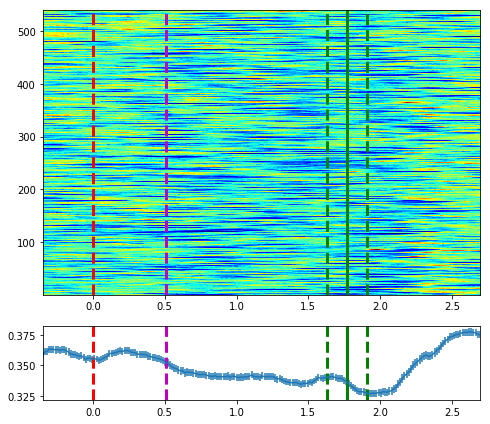

In [164]:
plt.figure(figsize=(10,6))
plt.subplot2grid((4,3), (0,0), colspan = 2, rowspan=3)
plt.imshow(aux, aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[net.tarray[0],net.tarray[-1], 1,540])
plt.vlines(0, 1, 540, linestyle='--', linewidth = 3, color = 'r')
plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                       1, 540, linestyle='--', linewidth = 3, color = 'm')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       1, 540, linestyle='-', linewidth = 3, color = 'g')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       1, 540, linestyle='--', linewidth = 3, color = 'g')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       1, 540, linestyle='--', linewidth = 3, color = 'g')
plt.subplot2grid((4,3), (3,0), colspan = 2, rowspan=1)
aux2  = aux.mean(axis = 0)
aux2e = aux.std(axis = 0) / np.sqrt(aux.shape[0])
plt.errorbar(net.tarray, aux2, aux2e)
plt.xlim([net.tarray[0], net.tarray[-1]])
plt.ylim([aux2.min()-0.005, aux2.max()+0.005])
plt.vlines(0, aux2.min()-0.005, aux2.max()+0.005, linestyle='--', linewidth = 3, color = 'r')
plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                       aux2.min()-0.005, aux2.max()+0.005, linestyle='--', linewidth = 3, color = 'm')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       aux2.min()-0.005, aux2.max()+0.005, linestyle='-', linewidth = 3, color = 'g')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       aux2.min()-0.005, aux2.max()+0.005, linestyle='--', linewidth = 3, color = 'g')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       aux2.min()-0.005, aux2.max()+0.005, linestyle='--', linewidth = 3, color = 'g')
plt.tight_layout()

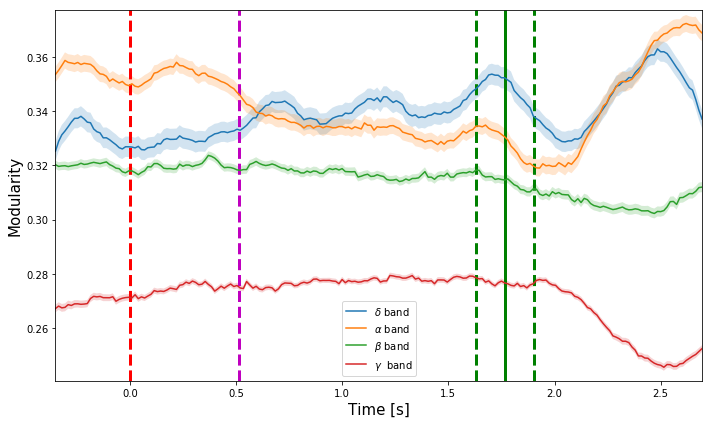

In [68]:
plt.figure(figsize=(10,6))
for i in range(4):
    m_mean = aux[i].mean(axis = 0)
    m_std  = aux[i].std(axis = 0) / np.sqrt(540)
    plt.plot(net.tarray, m_mean, label = bands[i] + ' band')
    plt.fill_between(net.tarray, m_mean-m_std, m_mean+m_std, alpha=0.2)
    #plt.errorbar(net.tarray, m_mean, m_std, label=bands[i] + ' band')
    #plt.title(bands[i] + ' band')
plt.xlim([net.tarray[0], net.tarray[-1]])
plt.ylim([aux.mean(axis=1).min()-0.005, aux.mean(axis=1).max()+0.005])
plt.vlines(0, aux.mean(axis=1).min()-0.005, aux.mean(axis=1).max()+0.005, linestyle='--', linewidth = 3, color = 'r')
plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                       aux.mean(axis=1).min()-0.005,aux.mean(axis=1).max()+0.005, linestyle='--', linewidth = 3, color = 'm')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       aux.mean(axis=1).min()-0.005, aux.mean(axis=1).max()+0.005, linestyle='-', linewidth = 3, color = 'g')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       aux.mean(axis=1).min()-0.005, aux.mean(axis=1).max()+0.005, linestyle='--', linewidth = 3, color = 'g')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       aux.mean(axis=1).min()-0.005, aux.mean(axis=1).max()+0.005, linestyle='--', linewidth = 3, color = 'g')
plt.ylabel('Modularity', fontsize=15)
plt.xlabel('Time [s]', fontsize=15)
plt.legend()
plt.tight_layout()

In [69]:
G = ig.Graph(g.edges)

In [72]:
G.coreness()

[6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 4,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 5,
 6,
 6,
 6]

In [88]:
coreness = np.zeros([49, len(net.bands), net.A.shape[-1]] )
for j in tqdm( range(len(net.bands)) ):
    for i in range(net.A.shape[-1]):
        g             = net.instantiate_graph(j, i, thr = net.coh_thr[j])
        G             = ig.Graph(49, g.edges)
        coreness[:,j,i] = G.coreness()

100%|██████████| 4/4 [06:00<00:00, 90.01s/it]


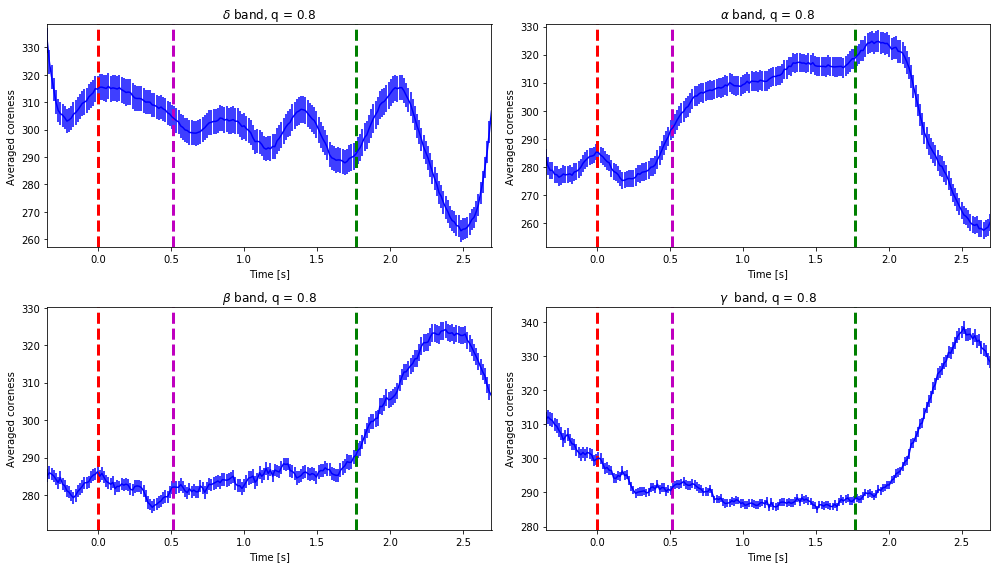

In [89]:
plt.figure(figsize=(14,8))
for j in range( len(net.bands) ):
    plt.subplot(2,2,j+1)
    s_d = coreness[:,j,:].sum(axis=0)
    s_d = s_d.reshape(540,len(net.tarray))
    s_d_m = s_d.mean(axis = 0)
    s_d_e = s_d.std(axis = 0) / (s_d.shape[0]**0.5)
    plt.errorbar(net.tarray, s_d_m, s_d_e, color = 'b')
    plt.title(bands[j] + ' band, q = 0.8')
    plt.xlim([net.tarray[0],net.tarray[-1]])
    plt.ylim([s_d_m.min()-6, s_d_m.max()+6])
    plt.vlines(0, s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'g')
    plt.ylabel('Averaged coreness')
    plt.xlabel('Time [s]')
plt.tight_layout()

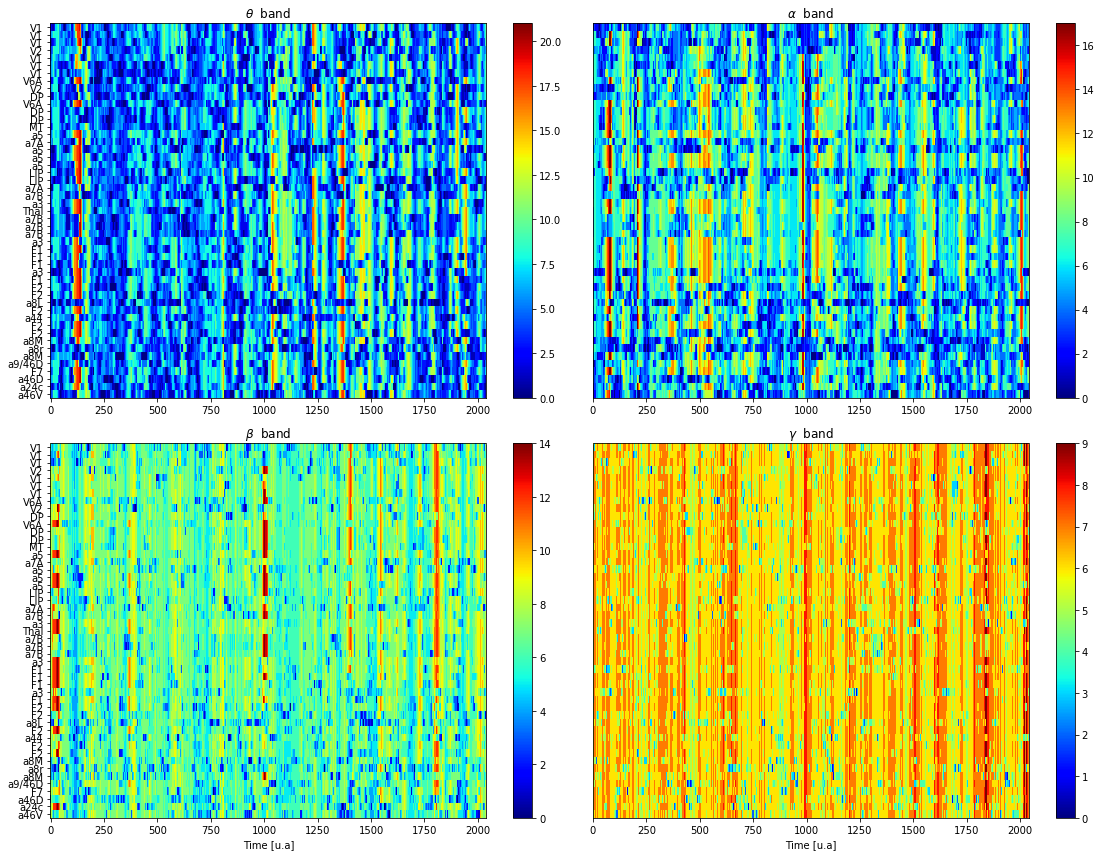

In [96]:
plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
plt.imshow(coreness[:,0,:10*len(net.tarray)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.yticks(range(49), net.session_info['areas'])
plt.title(r'$\theta$  band')
plt.subplot(2,2,2)
plt.imshow(coreness[:,1,:10*len(net.tarray)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.yticks([])
plt.title(r'$\alpha$  band')
plt.subplot(2,2,3)
plt.imshow(coreness[:,2,:10*len(net.tarray)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.yticks(range(49), net.session_info['areas'])
plt.title(r'$\beta$  band')
plt.xlabel('Time [u.a]')
plt.subplot(2,2,4)
plt.imshow(coreness[:,3,:10*len(net.tarray)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.yticks([])
plt.title(r'$\gamma$  band')
plt.xlabel('Time [u.a]')
plt.tight_layout()

In [95]:
coreness[:,0,:10*len(net.tarray)].shape

(49, 2040)

In [97]:
def igraph_measures(graph, func):
    return graph.func()

In [98]:
igraph_measures(G, coreness())

TypeError: 'numpy.ndarray' object is not callable

In [109]:
aux

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [150]:
A = net.A[:,:,1,i] + net.A[:,:,1,i].T
g = ig.Graph.Adjacency((A>net.coh_thr[1]).tolist())

In [151]:
leidenalg.find_partition(g, leidenalg.ModularityVertexPartition).modularity

In [154]:
a  = leidenalg.find_partition(g, leidenalg.ModularityVertexPartition)

In [28]:
j = 0

In [29]:
        net.compute_nodes_degree(j, thr = net.coh_thr[j])
        # Strength
        net.compute_nodes_degree(j, thr = None)
        strength = net.node_degree[0,:,j,:].sum(axis=0)
        degree   = net.node_degree[1,:,j,:].sum(axis=0)

In [32]:
np.mean((strength - degree)**2)

581565.4893180759

In [34]:
np.corrcoef(strength, degree)

array([[1.        , 0.95344028],
       [0.95344028, 1.        ]])

(60000, 60500)

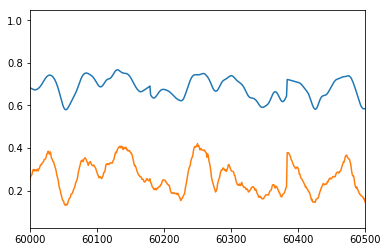

In [37]:
plt.plot(strength/strength.max())
plt.plot(degree/degree.max())
plt.xlim([60000,60500])

In [90]:
i,j=np.triu_indices_from(net.A[:,:,0,0], k=1)

In [62]:
j-net.session_info['pairs'][:,1]

array([0, 0, 0, ..., 0, 0, 0])

In [65]:
net.A[i,j,0,0]

array([0.59488742, 0.64637253, 0.33867008, ..., 0.61709937, 0.25596601,
       0.50940236])

In [66]:
i

array([ 0,  0,  0, ..., 46, 46, 47])

In [67]:
j

array([ 1,  2,  3, ..., 47, 48, 48])

In [70]:
net.A[0,2,0,0]

0.646372526884079

In [74]:
for i in zip(*indices):
    print(i)

(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(0, 6)
(0, 7)
(0, 8)
(0, 9)
(0, 10)
(0, 11)
(0, 12)
(0, 13)
(0, 14)
(0, 15)
(0, 16)
(0, 17)
(0, 18)
(0, 19)
(0, 20)
(0, 21)
(0, 22)
(0, 23)
(0, 24)
(0, 25)
(0, 26)
(0, 27)
(0, 28)
(0, 29)
(0, 30)
(0, 31)
(0, 32)
(0, 33)
(0, 34)
(0, 35)
(0, 36)
(0, 37)
(0, 38)
(0, 39)
(0, 40)
(0, 41)
(0, 42)
(0, 43)
(0, 44)
(0, 45)
(0, 46)
(0, 47)
(0, 48)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(1, 10)
(1, 11)
(1, 12)
(1, 13)
(1, 14)
(1, 15)
(1, 16)
(1, 17)
(1, 18)
(1, 19)
(1, 20)
(1, 21)
(1, 22)
(1, 23)
(1, 24)
(1, 25)
(1, 26)
(1, 27)
(1, 28)
(1, 29)
(1, 30)
(1, 31)
(1, 32)
(1, 33)
(1, 34)
(1, 35)
(1, 36)
(1, 37)
(1, 38)
(1, 39)
(1, 40)
(1, 41)
(1, 42)
(1, 43)
(1, 44)
(1, 45)
(1, 46)
(1, 47)
(1, 48)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(2, 7)
(2, 8)
(2, 9)
(2, 10)
(2, 11)
(2, 12)
(2, 13)
(2, 14)
(2, 15)
(2, 16)
(2, 17)
(2, 18)
(2, 19)
(2, 20)
(2, 21)
(2, 22)
(2, 23)
(2, 24)
(2, 25)
(2, 26)
(2, 27)
(2, 28)
(2, 29)
(2, 30)
(2, 31)
(2, 32)
(2, 33)
(2, 34)
(2, 35)


In [73]:
indices

(array([ 0,  0,  0, ..., 46, 46, 47]), array([ 1,  2,  3, ..., 47, 48, 48]))

In [19]:
# Creating igraph (method 1)
G = nx.Graph(net.A[:,:,0,0]>net.coh_thr[0])
g = ig.Graph(G.edges)

In [98]:
leidenalg.find_partition(g, leidenalg.ModularityVertexPartition).modularity
g.coreness()

[4,
 2,
 5,
 2,
 4,
 4,
 3,
 5,
 2,
 4,
 4,
 0,
 4,
 0,
 4,
 5,
 4,
 4,
 5,
 2,
 5,
 2,
 4,
 4,
 4,
 3,
 2,
 0,
 4,
 5,
 3,
 4,
 2,
 5,
 4,
 2,
 2,
 2,
 4,
 2,
 2,
 1,
 2,
 3,
 2,
 2,
 2,
 2,
 3]

In [97]:
# Creating igraph (method 2)
adj = (net.A[:,:,0,0]>net.coh_thr[0]).astype(int).tolist()
g   = ig.Graph.Adjacency(adj)

In [95]:
leidenalg.find_partition(g, leidenalg.ModularityVertexPartition).modularity
g.coreness()

[4,
 2,
 5,
 2,
 4,
 4,
 3,
 5,
 2,
 4,
 4,
 0,
 4,
 0,
 4,
 5,
 4,
 4,
 5,
 2,
 5,
 2,
 4,
 4,
 4,
 3,
 2,
 0,
 4,
 5,
 3,
 4,
 2,
 5,
 4,
 2,
 2,
 2,
 4,
 2,
 2,
 1,
 2,
 3,
 2,
 2,
 2,
 2,
 3]

In [91]:
# Creating graph (method 3)
adj = (net.A[:,:,0,0]>net.coh_thr[0]).astype(int)
i,j = np.where(adj == 1)
g   = ig.Graph(49, zip(i,j))

In [93]:
leidenalg.find_partition(g, leidenalg.ModularityVertexPartition).modularity
g.coreness()

[4,
 2,
 5,
 2,
 4,
 4,
 3,
 5,
 2,
 4,
 4,
 0,
 4,
 0,
 4,
 5,
 4,
 4,
 5,
 2,
 5,
 2,
 4,
 4,
 4,
 3,
 2,
 0,
 4,
 5,
 3,
 4,
 2,
 5,
 4,
 2,
 2,
 2,
 4,
 2,
 2,
 1,
 2,
 3,
 2,
 2,
 2,
 2,
 3]

In [82]:
j

array([ 7, 15, 19, 22, 24, 25, 33, 25, 47,  4,  7, 15, 17, 18, 20, 29,  4,
        9, 46,  9, 14, 15, 17, 18, 28, 29,  6, 12, 16, 28, 33, 47, 12, 22,
       48, 15, 18, 20, 26, 29, 31, 33, 19, 30, 12, 16, 17, 18, 24, 28, 29,
       14, 15, 18, 25, 38, 16, 19, 22, 24, 28, 30, 33, 48, 15, 20, 38, 18,
       20, 29, 33, 38, 43, 28, 29, 33, 35, 26, 29, 20, 29, 33, 34, 38, 43,
       29, 31, 33, 34, 38, 23, 26, 23, 24, 33, 24, 31, 33, 28, 43, 29, 33,
       31, 33, 31, 34, 48, 34, 38, 37, 39, 44, 38, 45, 37, 45, 41, 42, 44,
       42, 43, 46, 42, 47, 48, 45, 47])

In [46]:
net.clustering[1,:,1,:]

array([[1.        ,        nan,        nan, ..., 0.3       , 0.5       ,
        0.33333333],
       [       nan,        nan,        nan, ..., 1.        , 1.        ,
        1.        ],
       [       nan,        nan,        nan, ..., 0.        ,        nan,
               nan],
       ...,
       [0.66666667, 1.        , 1.        , ..., 0.46666667, 0.46666667,
        0.4       ],
       [0.66666667, 0.66666667, 0.6       , ..., 1.        , 1.        ,
        1.        ],
       [       nan,        nan,        nan, ..., 0.33333333, 1.        ,
        1.        ]])

In [44]:
np.isnan

<ufunc 'isnan'>

In [53]:
np.nan_to_num(net.clustering[1,:,j,:])

array([[0.        , 0.        , 0.        , ..., 0.57352941, 0.58088235,
        0.60952381],
       [0.        , 0.        , 0.        , ..., 0.4       , 0.46666667,
        0.39285714],
       [0.5       , 0.46666667, 0.6       , ..., 0.44444444, 0.42857143,
        0.47619048],
       ...,
       [0.        , 0.        , 0.        , ..., 0.66666667, 0.53333333,
        0.73333333],
       [0.        , 0.        , 0.        , ..., 0.7       , 0.66666667,
        0.7       ],
       [0.        , 0.        , 0.        , ..., 0.3030303 , 0.28787879,
        0.34848485]])

In [57]:
net.coh_thr

array([0.77950269, 0.56620128, 0.31758434, 0.16527808])

In [58]:
net.compute_coherence_thresholds(q = .8)

In [59]:
net.coh_thr

array([0.69730076, 0.47403168, 0.25120367, 0.12849101])

In [17]:
net.compute_nodes_betweenness(band=0, thr=net.coh_thr[0], use='igraph')
net.compute_nodes_betweenness(band=1, thr=net.coh_thr[1], use='igraph')
net.compute_nodes_betweenness(band=2, thr=net.coh_thr[2], use='igraph')
net.compute_nodes_betweenness(band=3, thr=net.coh_thr[3], use='igraph')

100%|██████████| 110160/110160 [01:58<00:00, 933.02it/s]


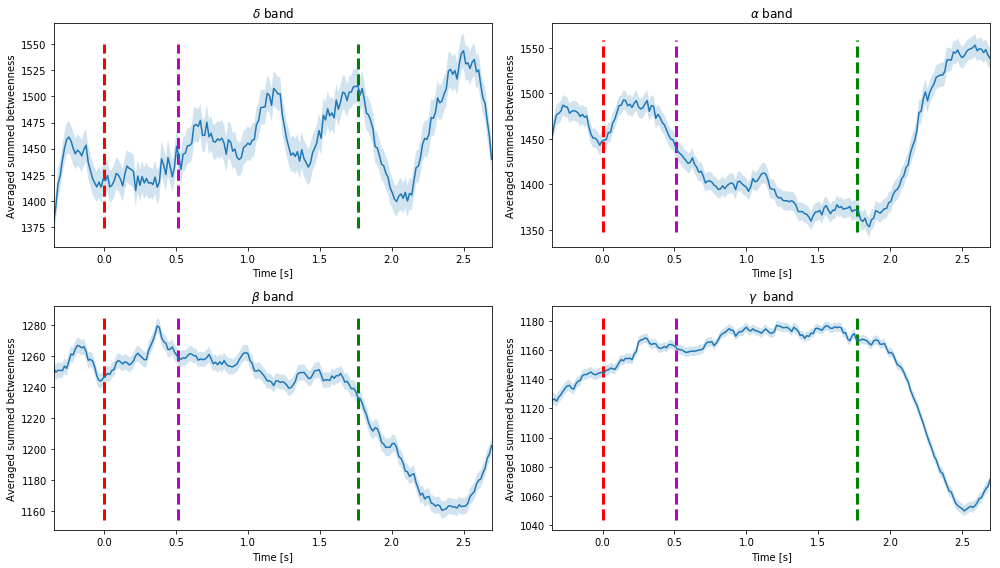

In [37]:
plt.figure(figsize=(14,8))
c = ['b', 'r']
for j in range( len(net.bands) ):
    plt.subplot(2,2,j+1)
    s_d = net.betweenness[1,:,j,:].sum(axis=0)
    s_d = s_d.reshape(540,len(net.tarray))
    s_d_m = np.mean(s_d, axis = 0)#s_d.median(axis = 0)
    s_d_e = s_d.std(axis = 0) / (s_d.shape[0]**0.5)
    plt.plot(net.tarray, s_d_m)
    plt.fill_between(net.tarray, s_d_m-s_d_e, s_d_m+s_d_e, alpha = .2)
    plt.title(bands[j] + ' band')
    plt.xlim([net.tarray[0],net.tarray[-1]])
    #plt.ylim([s_d_m.min()-6, s_d_m.max()+6])
    plt.vlines(0, s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                   s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                   s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'g')
    plt.ylabel('Averaged summed betweenness')
    plt.xlabel('Time [s]')
plt.tight_layout()

In [32]:
np.quantile(s_d, 0.90, axis=0)-np.median(s_d, axis=0)

array([113.7, 107.6, 114.5, 105.5, 100.2, 100. , 111. , 105.1, 106. ,
       104. ,  95.8,  98.1, 100.1, 108.2,  96. ,  96.2,  99. ,  96. ,
       102.5, 100.6, 110.1, 108. , 115. , 101. , 102.1, 107.6, 106.5,
       106.5, 110.5, 104. , 104.1, 107.5,  93. ,  97.1,  99.1,  97. ,
        98.1, 103. , 100. , 101.1, 104. ,  98. ,  93.1,  87.5,  98. ,
        82.2,  87. ,  90.1,  92.5,  91. ,  93.6,  92.6,  87.1,  98. ,
        94. , 103. ,  98. ,  90.8, 108. ,  95.5, 100. , 102.5, 103.3,
       111.7, 101.2, 101.2, 102. , 102.2, 100. , 103.2,  95. , 100.7,
       106. , 104.5,  97.5,  91.2,  85.5, 101.6,  96.5,  98. ,  96.5,
        96.5, 103.1, 101. ,  93.6,  91.7,  91. ,  88.1,  83.2,  92.5,
        90.1,  87.2,  85. ,  86. ,  86.5, 100.8,  95.5,  98.1,  96.1,
       101. ,  99. ,  99. , 100.7,  96.1, 105.2, 107. , 101.2,  95.7,
        94.6,  92. ,  93.6,  91.1,  89.5,  94. ,  97.5,  96.1,  95. ,
        93.1,  98. ,  94. ,  90. ,  79. ,  91. ,  92.6,  93.6,  89. ,
        96.1,  93.1,

In [28]:
s_d.shape

(540, 204)

In [39]:
from teneto import TemporalNetwork, networkmeasures, communitymeasures, communitydetection

In [42]:
ADJ = net.A[:,:,1,:204] + np.transpose(net.A[:,:,1,:204], (1,0,2))
#ADJ = ADJ > net.coh_thr[1]

In [43]:
tnet = TemporalNetwork(from_array = ADJ, nettype='wu')

In [44]:
tdc = networkmeasures.temporal_degree_centrality(tnet, calc = 'pertime')

In [45]:
start = time.time()
out   = communitydetection.temporal_louvain(tnet, njobs=40,  resolution=1)
end   = time.time()
print(end-start)

0
           i     j  weight
0          0     1     1.0
1         49    50     1.0
2         98    99     1.0
3        147   148     1.0
4        196   197     1.0
5        245   246     1.0
6        294   295     1.0
7        343   344     1.0
8        392   393     0.6
9        441   442     1.0
10       490   491     1.0
11       539   540     1.0
12       588   589     1.0
13       637   638     1.0
14       686   687     1.0
15       735   736     1.0
16       784   785     1.0
17       833   834     1.0
18       882   883     1.0
19       931   932     0.8
20       980   981     1.0
21      1029  1030     1.0
22      1078  1079     1.0
23      1127  1128     1.0
24      1176  1177     1.0
25      1225  1226     1.0
26      1274  1275     1.0
27      1323  1324     1.0
28      1372  1373     1.0
29      1421  1422     1.0
...      ...   ...     ...
247093  9917  9966     0.0
247094  9918  9967     0.0
247095  9919  9968     0.0
247096  9920  9969     0.0
247097  9921  9970     0.0

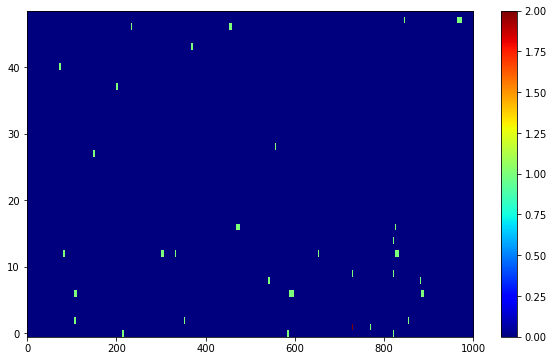

In [38]:
plt.figure(figsize = (10,6))
plt.imshow(out, aspect = 'auto', cmap = 'jet', origin = 'lower');plt.colorbar()

In [31]:
aux = tdc.reshape([49,540, len(net.tarray)])

In [35]:
a   = aux.sum(axis = 0)
b   = a.mean(axis=0)

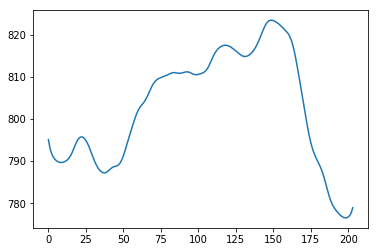

In [37]:
plt.plot(b)

In [130]:
A = (net.A[:,:,3,:] + np.transpose(net.A[:,:,3,:], (1,0,2)) )>net.coh_thr[3]
idx = np.arange(A.shape[-1])
np.random.shuffle( idx )
A = A[:,:,idx]

In [131]:
den = np.sum(A[:,:,0:-1] * A[:,:,1:], axis = 1)
num = np.sqrt( A[:,:,0:-1].sum(axis = 1) * A[:,:,1:].sum(axis = 1) )
Ci  = np.nansum(( den / num ), axis=1) / (A.shape[-1]-1)
C   = np.nansum(Ci) / len(Ci)

/opt/ohpc/pub/libs/gnu8/python/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [132]:
C

0.2361568878156426

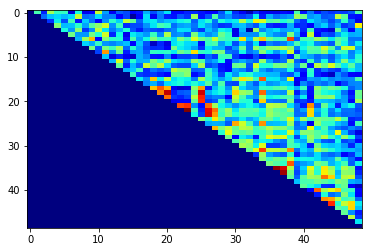

In [33]:
plt.imshow(net.A[:,:,1,10], aspect = 'auto', cmap = 'jet')

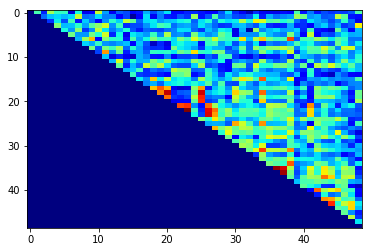

In [34]:
plt.imshow(A[:,:,2072], aspect = 'auto', cmap = 'jet')

In [133]:
def temporalCorrelation(adj):
    T      = adj.shape[2]
    nNodes = adj.shape[0]
    C_vec  = np.zeros(nNodes)
    
    for node_i in tqdm(range(nNodes)):
        gammaVec = np.zeros(T-1)
        for t in range(0, T-1):
            num = 0
            for j in range(nNodes):
                if node_i != j:
                    num += adj[node_i,j,t]*adj[node_i,j,t+1]
            
            den = np.sqrt( np.sum(adj[node_i,:,t])*np.sum(adj[node_i,:,t+1]) )
            
            if den != 0:
                gamma = num / den
                gammaVec[t] = gamma
            
        C_i = np.sum(gammaVec)/(T-1)
        C_vec[node_i] = C_i
    
    return np.sum(C_vec)/nNodes
    

In [134]:
temporalCorrelation(A)

100%|██████████| 49/49 [27:08<00:00, 33.24s/it]


0.236156887815698

In [135]:
C

0.2361568878156426

In [100]:
a = None

In [101]:
a!=None

False

In [42]:
A   = net.A[:,:,1,:] +  np.transpose( net.A[:,:,1,:], (1,0,2) )
idx = np.arange(49)
np.random.shuffle(idx)
An  = A[:,idx]

In [46]:
s1 = A.sum(axis = 1).sum(axis = 0)

In [47]:
s2 = An.sum(axis = 1).sum(axis = 0)

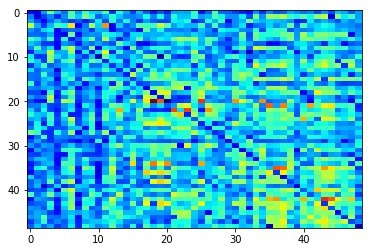

In [41]:
plt.imshow(A+An.T, aspect='auto', cmap = 'jet')

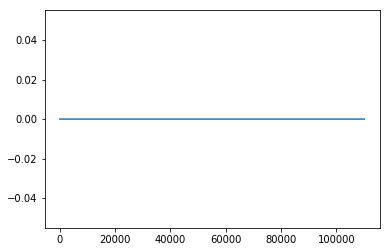

In [49]:
plt.plot(s1-s2)
#plt.plot(s2, '--')

In [22]:
net.create_null_model(randomize = 'edge')

In [23]:
net.A_null

AttributeError: 'temporal_network' object has no attribute 'A_null'

In [37]:
A   = net.A[:,:,1,0] + net.A[:,:,1,0].T

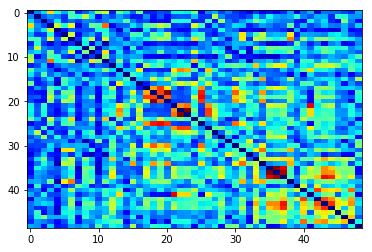

In [38]:
plt.imshow(A, aspect='auto', cmap = 'jet')

In [39]:
i,j = np.triu_indices_from(A, k=1)

In [40]:
A[j,i] = 0

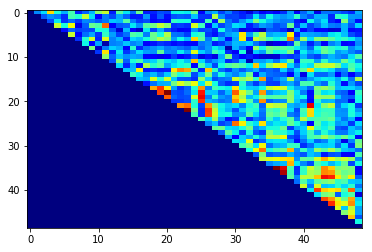

In [41]:
plt.imshow(A, aspect='auto', cmap = 'jet')

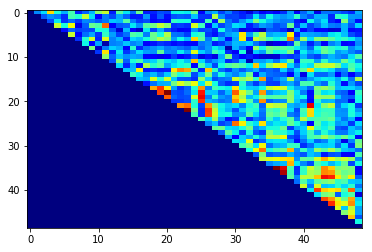

In [42]:
plt.imshow(net.A[:,:,1,0], aspect='auto', cmap = 'jet')

In [43]:
i,j = np.triu_indices_from(net.A, k=1)

ValueError: input array must be 2-d

In [44]:
net.A

(49, 49, 4, 110160)

In [51]:
np.multiply(, axes = (0,1))

TypeError: 'axes' is an invalid keyword to ufunc 'multiply'

In [16]:
net.create_null_model(randomize = 'edges')

In [43]:
net.A_null

array([[[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]],

        [[0.14286114, 0.36614782, 0.34119067, ..., 0.28562107,
          0.75525841, 0.42917261],
         [0.35925527, 0.20885986, 0.41984809, ..., 0.37041519,
          0.18863874, 0.17198342],
         [0.20079946, 0.15344043, 0.02655055, ..., 0.25960083,
          0.04151781, 0.00788446],
         [0.04619134, 0.11784143, 0.04655382, ..., 0.09218899,
          0.12227253, 0.01521643]],

        [[0.22113867, 0.04067854, 0.86893135, ..., 0.28112506,
          0.37894001, 0.26127122],
         [0.32948737, 0.34893421, 0.44911133, ..., 0.23013866,
          0.14008992, 0.48167288],
         [0.1094

In [23]:
st_delta.shape

(49, 4, 110160)

In [25]:
st_delta[:,1,:]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [25]:
s_d_m

array([795.11158143, 793.15335134, 791.92592488, 791.13514854,
       790.59408847, 790.20382131, 789.92683539, 789.75601499,
       789.68379048, 789.69283807, 789.76923112, 789.91064692,
       790.12248283, 790.42369128, 790.85172338, 791.4414128 ,
       792.19179003, 793.04890863, 793.91577192, 794.68506772,
       795.27331118, 795.63643667, 795.76561034, 795.67331343,
       795.38008233, 794.90525002, 794.26383469, 793.47461843,
       792.57320397, 791.61708379, 790.67466851, 789.80588077,
       789.05121556, 788.42901635, 787.93783783, 787.57025227,
       787.32671063, 787.21626827, 787.24926581, 787.42322489,
       787.70667008, 788.03671897, 788.34071867, 788.5668999 ,
       788.70495064, 788.79490659, 788.92103022, 789.18374563,
       789.65864804, 790.3695681 , 791.29048961, 792.36607641,
       793.53238219, 794.73543618, 795.940755  , 797.12695742,
       798.27948443, 799.38644909, 800.42509853, 801.35148101,
       802.12057659, 802.7237967 , 803.20329621, 803.63

In [17]:
a=np.array([1,2,3])

In [19]:
a>None

TypeError: '>' not supported between instances of 'int' and 'NoneType'

In [18]:
net.compute_network_modularity

<bound method temporal_network.compute_network_modularity of <GDa.temporal_network.temporal_network object at 0x7f1ddc556f28>>

In [21]:
m_delta.shape

(110160,)

In [25]:
m_delta.shape

(110160,)